# Projet final  ( lgp @work )

### Acquisition et chargement des données

* Récupération des fichiers Excel avec les classements
* Mise en place d'une copie locale des fichiers Excel afin de ne pas les recharger à chaque run.
* Vers la fin de la course le format des fichiers Excel change avec les arrivées des voiliers : il est possible de s'arrêter juste avant.
* Extraction des caractéristiques techniques de chacun des voiliers.




In [1]:
# Chargement des libs
import pandas as pd
import os
import sys
from bs4 import BeautifulSoup as bs
import requests
import datetime as dt
import dateparser
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# libs for xlsx "xxid" fix
import tempfile
from zipfile import ZipFile
import shutil
from fnmatch import fnmatch
import re
import glob
#

# variables utiliséees globalement
URL_RESULTS="https://www.vendeeglobe.org/fr/classement"
FILE_RESULTS="classement.html"
URL_GLOSSAIRE="https://www.vendeeglobe.org/fr/glossaire"
FILE_GLOSSAIRE="glossaire.html"
EXCELS_DIR="results"
PICKLE_DF="pickle_classement.pkl"
PICKLE_DF_TECH="pickle_classement_et_tech.pkl"


* Récupération des fichiers Excel avec les classements
* Mise en place d'une copie locale des fichiers Excel afin de ne pas les recharger à chaque run.
* Chargement dans un dataframe (clean up et split des noms de colonne, préparation des data pour traitements)

In [2]:
def get_soup_from_url(url):
    """
    Retourne la soupe de l'url du fichier html passé en paramètre
    """
    res = requests.get(url)
    soup = bs(res.content, 'html.parser')
    return soup

def get_soup_from_file(file):
    """
    Retourne la soupe du fichier html passé en paramètre
    """
    soup = bs(file, 'html.parser')
    return soup

def parse_url_for_excels(url):
    """
    Récupère la liste des fichiers excel et les télécharge dans le répertoire "results/" (EXCELS_DIR)
    """
    print("Getting url of files to download...")
    soup = get_soup_from_url(url)
    dates_list = []
    for option in soup.find_all('option'):
        if option['value'] != '':
            dates_list.append(option['value'])
    
    # format de fichiers à récupérer 
    # https://www.vendeeglobe.org/download-race-data/vendeeglobe_20210305_080000.xlsx
    print("Downloading xlsx files...")
    for date in dates_list:
        xlsx_name = f'vendeeglobe_{date}.xlsx'
        xlsx_file = requests.get(f"https://www.vendeeglobe.org//download-race-data/{xlsx_name}")
        open(os.path.join(EXCELS_DIR, xlsx_name), 'wb').write(xlsx_file.content)

def fix_xlsx_errors():
    """
    Fix des fichiers xlsx, un header xxid dans un des fichiers du xlsx n'est pas reconnu par openpyxl
    """
    print("Fixing xlsx files...")
    for file in [f for f in glob.glob(EXCELS_DIR + "/*.xlsx")]:
        change_in_zip(file, name_filter='xl/styles.xml', # the problematic property is found in the style xml files
                      change=lambda d: re.sub(b'xxid="\d*"', b"", d))
        
# fix of xlsx files
def change_in_zip(file_name, name_filter, change):
    """
    le fix appliqué à chaque fichier
    """
    tempdir = tempfile.mkdtemp()
    try:
        tempname = os.path.join(tempdir, 'new.zip')
        with ZipFile(file_name, 'r') as r, ZipFile(tempname, 'w') as w:
            for item in r.infolist():
                data = r.read(item.filename)          
                data = change(data)
                w.writestr(item, data)
        shutil.move(tempname, file_name)
    finally:
        shutil.rmtree(tempdir)


def get_excel_files():
    if not os.path.isdir(EXCELS_DIR):
        os.mkdir('results')
        print("Files being downloaded to ", EXCELS_DIR)
        parse_url_for_excels(URL_RESULTS)
        fix_xlsx_errors()
    else:
        print(f"Les fichiers sont déjà dans le répertoire \"{EXCELS_DIR}/\" et déjà traités, aucun nouveau fichier téléchargé ni traité.")


**L'appel à la commande *get_excel_files.xlsx* ne fait rien si le répertoire *results/* existe. Il est crée lors du 1er téléchargement** 

In [3]:
get_excel_files()

Les fichiers sont déjà dans le répertoire "results/" et déjà traités, aucun nouveau fichier téléchargé ni traité.


In [4]:
%%time
def create_dataframe_from_files(path, verbose=True):
    """
    Sélection des fichiers et concatenate dans une dataframe
    
    Returns a dataframe
    """
    if not verbose:
        print("Quiet mode activated. Be patient...", end='')
    dfs=[]
    for filename in [f for f in glob.glob(path + "/*.xlsx")]:
        # on exclu les fichiers donnant des infos sur les concurrents arrivées (à partir du 27 janvier)
        # on exclu le 1er fichier au départ qui est sans données
        if filename >= path+'/vendeeglobe_20210127_170000.xlsx' or filename == path+"/vendeeglobe_20201108_120200.xlsx":
            continue
        if verbose:
            print('Including file ', filename)

        # read excel
        x = pd.read_excel(filename, 
                          dtype=object,
                          skiprows=[1, 2, 3], 
                          header=1, 
                          usecols=range(1,21), 
                          skipfooter=4)
        # do not use col 0
        # remove footer
        # rename 1  Classement
        # split 2 on \n rename Pays /  Voile
        # split 3 on \n ren Skipper /  Bateau
        # change names

        # ajout colonne avec le timestamp du fichier d'où est extrait la data
        date_str = filename[-20:-5]
        x['Fichier de resultats'] = date_str
        x['Timestamp'] = pd.to_datetime(date_str, format="%Y%m%d_%H%M%S")
        dfs.append(x)
    
    df = pd.concat(dfs , ignore_index=True)
    #df.duplicated().value_counts()

    if not verbose:
        print("done")
    return df

def clean_data(df, verbose=True):
    """
    Cleanup des noms de colonnes
    """
    print('Cleaning dataframe... ', end='')

    # cleanup sur nom dde cols, etc.
    df.rename(inplace=True, columns={'Unnamed: 1': 'Classement', 'Unnamed: 2': 'Pays', 'Unnamed: 3': 'Skipper', 
                                    'Unnamed: 19': 'DTF', 'Unnamed: 20': 'DTL', "Heure FR\nHour FR": "Heure FR"})
    df[['Pays','Voile']] = df["Pays"].str.extract("(.*)\n(.*)").astype(str)
    df[['Skipper','Bateau']] = df["Skipper"].str.extract("(.*)\n(.*)").astype(str)
    df[['Heure FR']] = df["Heure FR"].str.extract("(.*)\n.*").astype(str)
    df.rename(inplace=True, columns={'Latitude\nLatitude': 'Latitude', 
                    'Longitude\nLongitude': 'Longitude', 
                    'Cap\nHeading': 'Cap 30m', 'Vitesse\nSpeed': 'Vitesse 30m', 
                    'VMG\nVMG': 'VMG 30m', 'Distance\nDistance': 'Distance 30m',
                    'Cap\nHeading.1': 'Cap dernier', 'Vitesse\nSpeed.1': 'Vitesse dernier', 
                    'VMG\nVMG.1': 'VMG dernier', 'Distance\nDistance.1': 'Distance dernier',
                    'Cap\nHeading.2': 'Cap 24h', 'Vitesse\nSpeed.2': 'Vitesse 24h', 
                    'VMG\nVMG.2': 'VMG 24h', 'Distance\nDistance.2': 'Distance 24h'})

    for col in ['Vitesse 30m','VMG 30m', 'Vitesse dernier', 'VMG dernier', 'Vitesse 24h', 'VMG 24h']:
        df[[col]] = df[col].str.extract("(.*) kts").astype(float)
    for col in ['Distance 30m', 'Distance dernier', 'Distance 24h', 'DTF', 'DTL']:
        df[[col]] = df[col].str.extract("(.*) nm").astype(float)
    for col in ['Cap 30m', 'Cap dernier', 'Cap 24h']:
        df[[col]] = df[col].str.extract("(\d*)°").astype(float)

    # classement des abandons trasnformé en int
    df[['Classement']] = df[['Classement']].applymap(lambda x: x.replace('RET', '34')).astype(str)
    df[['Classement']] = df[['Classement']].applymap(lambda x: x.replace('NL', '35')).astype(str)
    
    # VMG : Velocity Made Good = projection du vecteur vitesse sur la route théorique. Ou plus simplement : vitesse de rapprochement au but.
    # DTF : Distance To Finish = Distance théorique la plus courte pour rejoindre l'arrivée; DTL : Distance To Leader = différence de distance au but avec le premier au classement

    # suppression des lignes avec Nan
    # ce sont les abandons
    df = df.dropna()

    print("done")
    return df

# backup dans un fichier pickle pour ne pas retraiter à chaque run
if not os.path.isfile(PICKLE_DF):
    print(f"\nLoading data from {EXCELS_DIR}/*.xlsx files")
    df = create_dataframe_from_files(EXCELS_DIR, verbose=False)
    df = clean_data(df)
    df.to_pickle(PICKLE_DF)
    print(f"{PICKLE_DF} saved")
else:
    print(f"\nLoading data from pickle file {PICKLE_DF}...", end='')
    df = pd.read_pickle(PICKLE_DF)
    print(' done')
    print(f'\n(Note: if you need to reset pickle content remove file {PICKLE_DF} manually)')
    
df.shape



Loading data from results/*.xlsx files
Quiet mode activated. Be patient...done
Cleaning dataframe... done
pickle_classement.pkl saved
CPU times: user 20.4 s, sys: 79.2 ms, total: 20.5 s
Wall time: 20.5 s


(13703, 24)

In [5]:
df.iloc[1]

Classement                                2
Pays                                       
Skipper                       Thomas Ruyant
Heure FR                           08:30 FR
Latitude                         31°20.72'S
Longitude                        18°13.22'W
Cap 30m                               122.0
Vitesse 30m                            10.2
VMG 30m                                10.2
Distance 30m                            5.1
Cap dernier                           135.0
Vitesse dernier                         9.2
VMG dernier                             9.1
Distance dernier                       36.9
Cap 24h                               119.0
Vitesse 24h                            11.2
VMG 24h                                11.1
Distance 24h                          268.9
DTF                                 19251.9
DTL                                    36.9
Fichier de resultats        20201124_080000
Timestamp               2020-11-24 08:00:00
Voile                           



#### Extraction des caractéristiques techniques de chacun des voiliers.

* Extraction des caractéristiques techniques de chacun des voiliers depuis la page glossaire 
* ajout des informations sur la présence de foils depuis la page classement



Traitement manuel de la page web https://www.vendeeglobe.org/fr/classement pour récupérer l'info sur les foils et le classement final

In [6]:
def get_infos_from_classement(df):
    """
    Récupère les infos skipper, foil, etc.
    
    Retourne une liste de liste de [classement final, nom skipper, Oui/Non (foil)]
    """
    print("Getting boats infos...")
    classement_html=""
    if not os.path.isfile(FILE_RESULTS):
        print("Reading file from far away")
        req = requests.get(URL_RESULTS)
        classement_html = req.content
        open(os.path.join(FILE_RESULTS), 'wb').write(classement_html)
    else:
        print("Reading file locally")
        with open(FILE_RESULTS,'r') as file:
            classement_html = file.read()

    soup = get_soup_from_file(classement_html)
    skippers_info=[]
    for ranking_row in soup.find_all("tr", {"class": "ranking-row"}):
        cell_rank = ranking_row.find('td', attrs={'class': 'row-number'} ).text
        cell_skipper = ranking_row.find('td', attrs={'class': 'row-skipper'} ).contents[2]
        cell_skipper = re.search(r'\n\s+(\w[\s\'\w-]*)', cell_skipper).group(1).title()
        cell_has_foil = ranking_row.find('td', attrs={'class': 'row-layout'} ).text
        skippers_info.append([cell_rank, cell_skipper, cell_has_foil])
    return skippers_info

# Extraction des caractéristiques techniques de chacun des voiliers.
def get_infos_from_glossaire():
    """
    Récupère les infos skipper, foil, etc.
    """
    if not os.path.isfile(FILE_GLOSSAIRE):
        print("Reading file from far away..." , end='')
        req = requests.get(URL_GLOSSAIRE)
        glossaire_html = req.content
        open(os.path.join(FILE_GLOSSAIRE), 'wb').write(glossaire_html.content)
    else:
        print("Reading file locally... " , end='')
        with open(FILE_GLOSSAIRE,'r') as file:
            glossaire_html = file.read()

    soup = get_soup_from_file(glossaire_html)
    
    tech_info={}
    
    boats_popup_infos = soup.find_all('div', attrs={'class': 'boats-list__popup-infos'})
    specs_list = soup.find_all('ul', attrs={'class': 'boats-list__popup-specs-list'})
#     print(len(boats_popup_infos), len(specs_list))
#     v = []
    for i in range(len(boats_popup_infos)):
        bateau = boats_popup_infos[i].h3.text
        specs = specs_list[i]
        voile = specs.find(string=re.compile("Numéro de voile : "))
        if voile == None:
            voile = 0
        else:
            voile = re.match(".*: ([\w\s]+)", voile)[1]
        anc_name = specs.find(string=re.compile("Anciens noms du bateau : "))
        if anc_name==None:
            anc_name = bateau
        else:    
            anc_name = re.match(".*: ([,\w\s]+)", anc_name)[1]
        Architecte = specs.find(string=re.compile("Architecte")) # : Marc Lombard</li>
        Architecte = re.match(".*: ([\s\w]+)", Architecte)[1]
        Chantier= specs.find(string=re.compile("Chantier")) #MAG France</li>
        Chantier= re.match(".*: ([\s\w]+)", Chantier)[1]
        lancement= specs.find(string=re.compile("Date de lancement")) # : 01 Mars 1998</li>
        lancement= re.match(".*: ([\s\w]+)", lancement)[1]
        Longueur= specs.find(string=re.compile("Longueur")) # : 18,28m</li>
        Longueur= re.match(".*: ([,.\d]+)", Longueur)[1]
        Largeur = specs.find(string=re.compile("Largeur")) # : 5,54m</li>
        Largeur = re.match(".*: ([,\d]+)", Largeur)[1]
        Tirant = specs.find(string=re.compile("Tirant d'eau")) # : 4,50m</li>
        Tirant = re.match(".*: ([,\d]+)", Tirant)[1]
        poids = specs.find(string=re.compile("Déplacement")) # : 9t</li>
        poids = re.match(".*: ([,\dncNC]+)\s?t?", poids)[1]
        if poids=="nc" or poids=="NC":
            poids="0"
        derives = specs.find(string=re.compile("Nombre de dérives")) # : 2</li>
        derives = re.match(".*: (.*)", derives)[1]
        mat = specs.find(string=re.compile("Hauteur mât")) # : 29 m</li>
        mat = re.match(".*: ([,\d]+)", mat)[1]
        quille = specs.find(string=re.compile("Voile quille")) # : acier</li>
        if quille == None:
            quille = "NC"
        else:
            quille = re.match(".*: ([\s\w]+)", quille)[1].lower() 
        Surface_pres = specs.find(string=re.compile("Surface de voiles au près")) # : 260 m2</li>
        Surface_pres = re.match(".*: ([,\d]+).*m[2²]", Surface_pres)[1]
        Surface_portant = specs.find(string=re.compile("Surface de voiles au portant")) # : 580 m2</li>
        Surface_portant = re.match(".*: ([,\d]+).*m[2²]", Surface_portant)[1]

        # manual cleanup des numéros de voiles qui ne matchent pas avec les fichiers classements
        if bateau == 'LinkedOut':
            voile = "FRA 59"
        if voile == "001":
            voile = "FRA 01"
        if voile == "4":
            voile = "FRA 4" 
        if voile == "2":
            voile = "FRA 02"
#         if voile == "6":
#                 voile = "FRA 6"
        if voile == "08":
            voile = "FRA 8"
        if voile == "16":
            voile = "MON 10"
        if voile == "17":
            voile = "FRA 17"
        if voile == "18":
            voile = "FRA 18"
        if voile == "69":
            voile = "FRA 69"
        if voile == "SUI07":
            voile = "SUI 7"
        if voile == "GBR77":
            voile = "GBR 777"
        if voile[3] != " ":
#             print(voile)
            voile = voile[0:3]+" "+voile[3:]
#             print(voile)
        tech_info[voile] = {'Voile': voile, 'Nom bateau': bateau, 'Longueur': Longueur, 
                            'Largeur': Largeur, 'Tirant': Tirant, 
                           'Poids': poids, "Dérives": derives,
                           'Hauteur mât': mat, "Quille": quille, 
                            "Surface près": Surface_pres,  "Surface portant": Surface_portant,
                           "Année lancement": lancement[-4:], 'Ancien nom': anc_name}
#         v.append(voile)
    print("Done")
    return tech_info



In [7]:

foils_etc = get_infos_from_classement(df)

# manual fixes
# skippers with names not matching
# from web page 2 errors
skips=set()
for f in foils_etc:
    skipper=f[1]
    skips.add(skipper)
all_skips = set(df['Skipper'])
# print(skips.difference(set(all_skips)))
df[['Skipper']] = df[['Skipper']].applymap(lambda x: x.replace('Arnaud Boissieres', 'Arnaud Boissières')).astype(str)

for f in foils_etc:
    if f[1]=="Sam Davies":
        skipper = "Samantha Davies"
    elif f[1]=="Alan  Roura":
        skipper="Alan Roura"
    else:
        skipper=f[1]
    foil=f[2]
    
    df.loc[df['Skipper']==skipper, 'Foil'] = foil
    df.loc[df['Skipper']==skipper, 'Classement final'] = f[0]

df[['Classement final']] = df[['Classement final']].applymap(lambda x: x.replace('ABD', '34')).astype(str)
df[['Classement final']] = df[['Classement final']].astype(int)
df[['Classement']] = df[['Classement']].astype(int)


# set(df['Skipper'])
df[['Foil']] = df[['Foil']].applymap(lambda x: x.replace('Oui', '1')).astype(str)
df[['Foil']] = df[['Foil']].applymap(lambda x: x.replace('Non', '0')).astype(str)
df[['Foil']] = df[['Foil']].astype(int)
# df[['Foil']] = df[['Foil']].astype(bool)



Getting boats infos...
Reading file locally


In [8]:
#################################################################################
# MERGE DES CLASSEMENTS ET DONNEES TECHNIQUES


# tech_info contains a dict of technical details
# backup dans un fichier pickle pour ne pas retraiter à chaque run
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#brief-primer-on-merge-methods-relational-algebra


mapping_quilles={}
mapping_derives={}
mapping_inv_quilles={}
mapping_inv_derives={}
def last_cleanup(df):
    ## cleanup columns types, changing categorical values to numbers, renaming and ordering

    df['Tirant'] = df["Tirant"].str.replace(',','.').astype(float)
    df['Longueur'] = df["Longueur"].str.replace(',','.').astype(float)
    df['Largeur'] = df["Largeur"].str.replace(',','.').astype(float)
    df['Poids'] = df["Poids"].str.replace(',','.').astype(float)
    df["Hauteur mât"] = df["Hauteur mât"].str.replace(',','.').astype(float)
    df["Surface près"] = df["Surface près"].str.replace(',','.').astype(float)
    df["Surface portant"] = df["Surface portant"].str.replace(',','.').astype(float)
    df["Année lancement"] = df["Année lancement"].astype(int)


    for i, name in enumerate(sorted(df['Quille'].unique())):
        mapping_quilles[i]=name
        mapping_inv_quilles[name]=i
    for i, name in enumerate(sorted(df['Dérives'].unique())):
        mapping_derives[i]=name
        mapping_inv_derives[name]=i

    # traitement du gender
    df['Dérives'] = df['Dérives'].map(mapping_inv_derives)
    df['Quille']  = df['Quille'].map(mapping_inv_quilles)
    df['Dérives'] = df['Dérives'].astype(int)
    df['Quille']  = df['Quille'].astype(int)

    columns=['Timestamp', 'Classement', 'Classement final', 'Skipper', 'Bateau', 'Voile', 'Pays', 'Heure FR', 'Latitude', 'Longitude',
           'Cap 30m', 'Vitesse 30m', 'VMG 30m', 'Distance 30m', 'Cap dernier',
           'Vitesse dernier', 'VMG dernier', 'Distance dernier', 'Cap 24h',
           'Vitesse 24h', 'VMG 24h', 'Distance 24h', 'DTF', 'DTL',
           'Fichier de resultats', 'Foil', 'Dérives', 'Tirant', 'Longueur', 'Largeur', 'Poids', 
           'Hauteur mât', 'Quille', 'Surface près', 'Surface portant',
           'Année lancement', 'Ancien nom']

    df = df[columns]
    return(df)

def merge(df):
    if not os.path.isfile(PICKLE_DF_TECH):  
        print(f"\nLoading boats technical data")
        tech_info = get_infos_from_glossaire()

        print(f"\nMerging df with technical data")
        df_tech_info = pd.DataFrame(tech_info).T        
        df_merge = pd.merge(df, df_tech_info, on="Voile")
        df_merge = last_cleanup(df_merge)

        df_merge.to_pickle(PICKLE_DF_TECH)
        print(f"Pickle file {PICKLE_DF_TECH} saved.")
    else:
        print(f"\nLoading data from pickle file {PICKLE_DF_TECH}...", end='')
        df_merge = pd.read_pickle(PICKLE_DF_TECH)
        print(' done')
        print(f'\n(Note: if you need to renew pickle content remove file {PICKLE_DF_TECH} manually)')
    return df_merge

df = merge(df)
mapping_derives, mapping_quilles



Loading boats technical data
Reading file locally... Done

Merging df with technical data
Pickle file pickle_classement_et_tech.pkl saved.


({0: '2', 1: '2 asymétriques', 2: 'foiler', 3: 'foils'},
 {0: 'NC',
  1: 'acier',
  2: 'acier forgé',
  3: 'acier mécano soudé',
  4: 'basculante avec vérin',
  5: 'basculante sur vérin hydraulique',
  6: 'carbone',
  7: 'inox usiné',
  8: 'monotype'})

### Dataframe prêt

Nous avons maintenant un dataframe complet avec toutes nos données.

Il comporte les données numériques y comppris le mapptignd e certianes cat"gories (dérives et quilles) détaillé ci-après.

#### Fichiers inclus/exclus

J'ai pris l'optino de ne pas intégrer les fichiers vers la fin de la course comme proposé dans l'énoncé. Les fichiers aprsè le 20210127_170000 ne sont pas intégrées au dataframe.

#### Classement général et classement final

Concernant les classements la position 34 représente un abandon.

#### Mapping  quilles et dérives

A l'étape précédente j'ai crée 2 mappings de données catégorielles pour les dérives et les quilles.
Les quilles et dérives en fonction des matériaux sont regroupés comme ceci.

<pre>
Mapping des dérives :
0: '2'
1: '2 asymétriques'
2: 'foiler'
3: 'foils'

Mapping des quilles:
0: 'NC'
1: 'acier'
2: 'acier forgé'
3: 'acier mécano soudé'
4: 'basculante avec vérin'
5: 'basculante sur vérin hydraulique'
6: 'carbone'
7: 'inox usiné'
8: 'monotype'
</pre>

#### Coordonnées 

La coordonnées au foramt exploitable ppour positionnementsr une carte


**Contrôle d'une donnée et des Dtypes**

In [9]:
df.iloc[2546]

Timestamp               2020-11-24 08:00:00
Classement                                7
Classement final                         34
Skipper                     Sébastien Simon
Bateau                         ARKEA PAPREC
Voile                                 FRA 4
Pays                                       
Heure FR                           08:30 FR
Latitude                         26°48.78'S
Longitude                        24°36.32'W
Cap 30m                               133.0
Vitesse 30m                             8.8
VMG 30m                                 8.8
Distance 30m                            4.4
Cap dernier                           131.0
Vitesse dernier                         8.5
VMG dernier                             8.4
Distance dernier                       33.8
Cap 24h                               129.0
Vitesse 24h                             8.4
VMG 24h                                 8.4
Distance 24h                          201.1
DTF                             

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13703 entries, 0 to 13702
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Timestamp             13703 non-null  datetime64[ns]
 1   Classement            13703 non-null  int64         
 2   Classement final      13703 non-null  int64         
 3   Skipper               13703 non-null  object        
 4   Bateau                13703 non-null  object        
 5   Voile                 13703 non-null  object        
 6   Pays                  13703 non-null  object        
 7   Heure FR              13703 non-null  object        
 8   Latitude              13703 non-null  object        
 9   Longitude             13703 non-null  object        
 10  Cap 30m               13703 non-null  float64       
 11  Vitesse 30m           13703 non-null  float64       
 12  VMG 30m               13703 non-null  float64       
 13  Distance 30m    

## Analyse des données


############################## AT WORK BELOW THIS LINE #####################################

In [11]:
# column_values = df[['Bateau', 'Voile']].values.ravel()
# unique_values =  pd.unique(column_values)
# unique_values
# s = set(df['Voile'].unique())
# s1-s

In [12]:
df_classements_14h = df.loc[ df['Fichier de resultats'].str.endswith("140000")]
df_classements_14h.head(1)

,Timestamp,Classement,Classement final,Skipper,Bateau,Voile,Pays,Heure FR,Latitude,Longitude,...,Tirant,Longueur,Largeur,Poids,Hauteur mât,Quille,Surface près,Surface portant,Année lancement,Ancien nom
1,2020-12-24 14:00:00,2,2,Charlie Dalin,APIVIA,FRA 79,,14:30 FR,55°00.33'S,151°58.60'W,...,4.5,18.28,5.85,8.0,29.0,1,350.0,560.0,2019,APIVIA


In [13]:
df.columns

Index(['Timestamp', 'Classement', 'Classement final', 'Skipper', 'Bateau',
       'Voile', 'Pays', 'Heure FR', 'Latitude', 'Longitude', 'Cap 30m',
       'Vitesse 30m', 'VMG 30m', 'Distance 30m', 'Cap dernier',
       'Vitesse dernier', 'VMG dernier', 'Distance dernier', 'Cap 24h',
       'Vitesse 24h', 'VMG 24h', 'Distance 24h', 'DTF', 'DTL',
       'Fichier de resultats', 'Foil', 'Dérives', 'Tirant', 'Longueur',
       'Largeur', 'Poids', 'Hauteur mât', 'Quille', 'Surface près',
       'Surface portant', 'Année lancement', 'Ancien nom'],
      dtype='object')

In [14]:
cols_temp = ['Classement', 'Classement final', 'Skipper', \
             'Bateau', 'Voile', 'Pays', 'Heure FR', 'Latitude', 'Longitude', \
             'Cap 24h', 'Vitesse 24h', 'VMG 24h', 'Distance 24h', 'DTF', 'DTL', \
             'Fichier de resultats', 'Foil', 'Dérives', 'Tirant', 'Longueur', 'Largeur', \
             'Poids', 'Hauteur mât', 'Quille', 'Surface près', 'Surface portant', \
             'Année lancement', 'Ancien nom']
df_temp = df_classements_14h[cols_temp]

def df_with_numerical_columns(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    num_df = df.select_dtypes(include=numerics)
    return num_df

num_df = df_with_numerical_columns(df_temp)

num_df


,Classement,Classement final,Cap 24h,Vitesse 24h,VMG 24h,Distance 24h,DTF,DTL,Foil,Dérives,Tirant,Longueur,Largeur,Poids,Hauteur mât,Quille,Surface près,Surface portant,Année lancement
1,2,2,86.0,11.9,11.8,286.3,9896.5,16.1,1,3,4.5,18.28,5.85,8.0,29.0,1,350.0,560.0,2019
7,1,2,139.0,11.6,11.4,279.2,19421.4,0.0,1,3,4.5,18.28,5.85,8.0,29.0,1,350.0,560.0,2019
11,1,2,2.0,14.1,12.2,337.8,2114.7,0.0,1,3,4.5,18.28,5.85,8.0,29.0,1,350.0,560.0,2019
16,2,2,25.0,12.6,12.6,302.1,4807.5,38.2,1,3,4.5,18.28,5.85,8.0,29.0,1,350.0,560.0,2019
17,8,2,225.0,9.1,8.4,219.5,23896.3,30.0,1,3,4.5,18.28,5.85,8.0,29.0,1,350.0,560.0,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13680,3,34,205.0,13.4,12.5,320.4,23200.5,47.6,1,3,4.5,18.28,5.70,7.9,27.3,0,270.0,535.0,2020
13686,20,34,195.0,0.2,0.1,4.5,24295.2,1.4,1,3,4.5,18.28,5.70,7.9,27.3,0,270.0,535.0,2020
13687,11,34,215.0,12.6,10.2,302.0,22969.4,122.1,1,3,4.5,18.28,5.70,7.9,27.3,0,270.0,535.0,2020
13688,6,34,262.0,12.4,7.8,297.5,24083.9,13.5,1,3,4.5,18.28,5.70,7.9,27.3,0,270.0,535.0,2020


In [15]:
nom_colonne_y = "Classement final"
Y = num_df[nom_colonne_y]

In [16]:
num_df.columns

Index(['Classement', 'Classement final', 'Cap 24h', 'Vitesse 24h', 'VMG 24h',
       'Distance 24h', 'DTF', 'DTL', 'Foil', 'Dérives', 'Tirant', 'Longueur',
       'Largeur', 'Poids', 'Hauteur mât', 'Quille', 'Surface près',
       'Surface portant', 'Année lancement'],
      dtype='object')

In [25]:
cols1=['Classement', 'Classement final', 'Cap 24h', 'VMG 24h', 'Distance 24h', 'Tirant', 'Longueur' ]
cols2=['Classement', 'Classement final', 'DTF', 'DTL', 'Vitesse 24h', 'Largeur']
cols3=['Classement', 'Classement final', 'Poids', 'Hauteur mât', 'Surface près',
       'Surface portant', 'Année lancement']
cols4=['Classement', 'Classement final', 'Foil', 'Dérives', 'Quille', 'Année lancement', 'Surface près',
       'Surface portant']
cols5=[ 'Année lancement', 'Classement final', 'Foil', 'Dérives', 'Poids' ]
df1 = num_df[cols1]
df2 = num_df[cols2]
df3 = num_df[cols3]
df4 = num_df[cols4]
df5 = num_df[cols5]

Index(['Année lancement', 'Classement final', 'Foil', 'Dérives', 'Poids'], dtype='object')

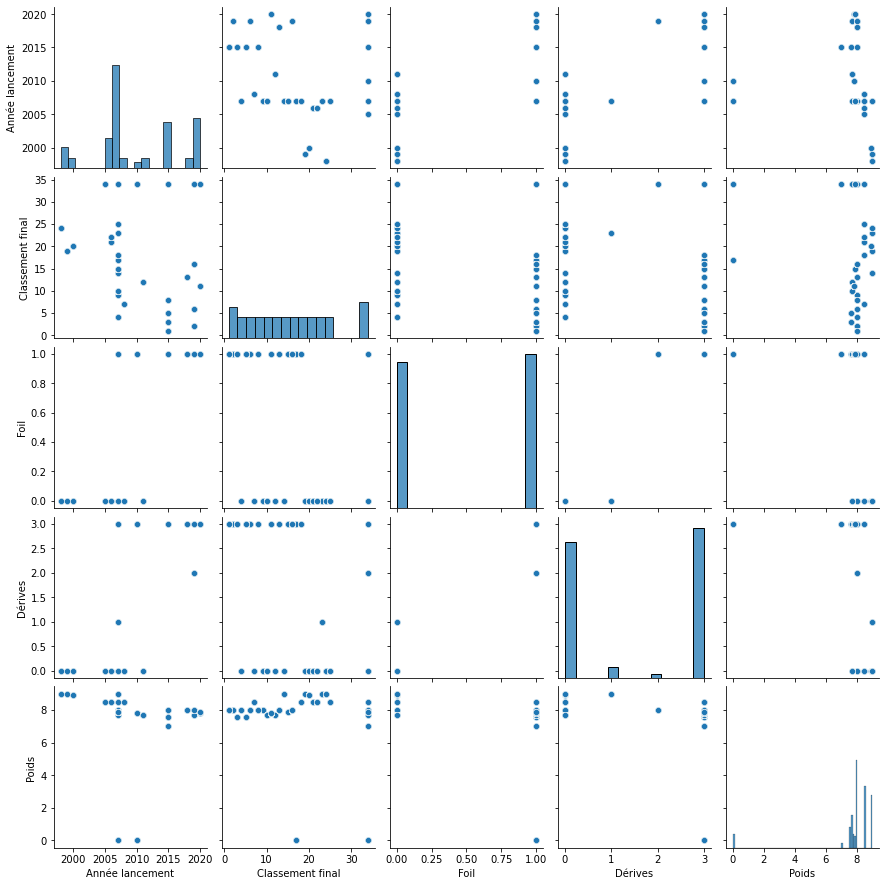

In [18]:
sns.pairplot(df5)
df5.columns

Index(['Classement', 'Classement final', 'Foil', 'Dérives', 'Quille',
       'Année lancement', 'Surface près', 'Surface portant'],
      dtype='object')

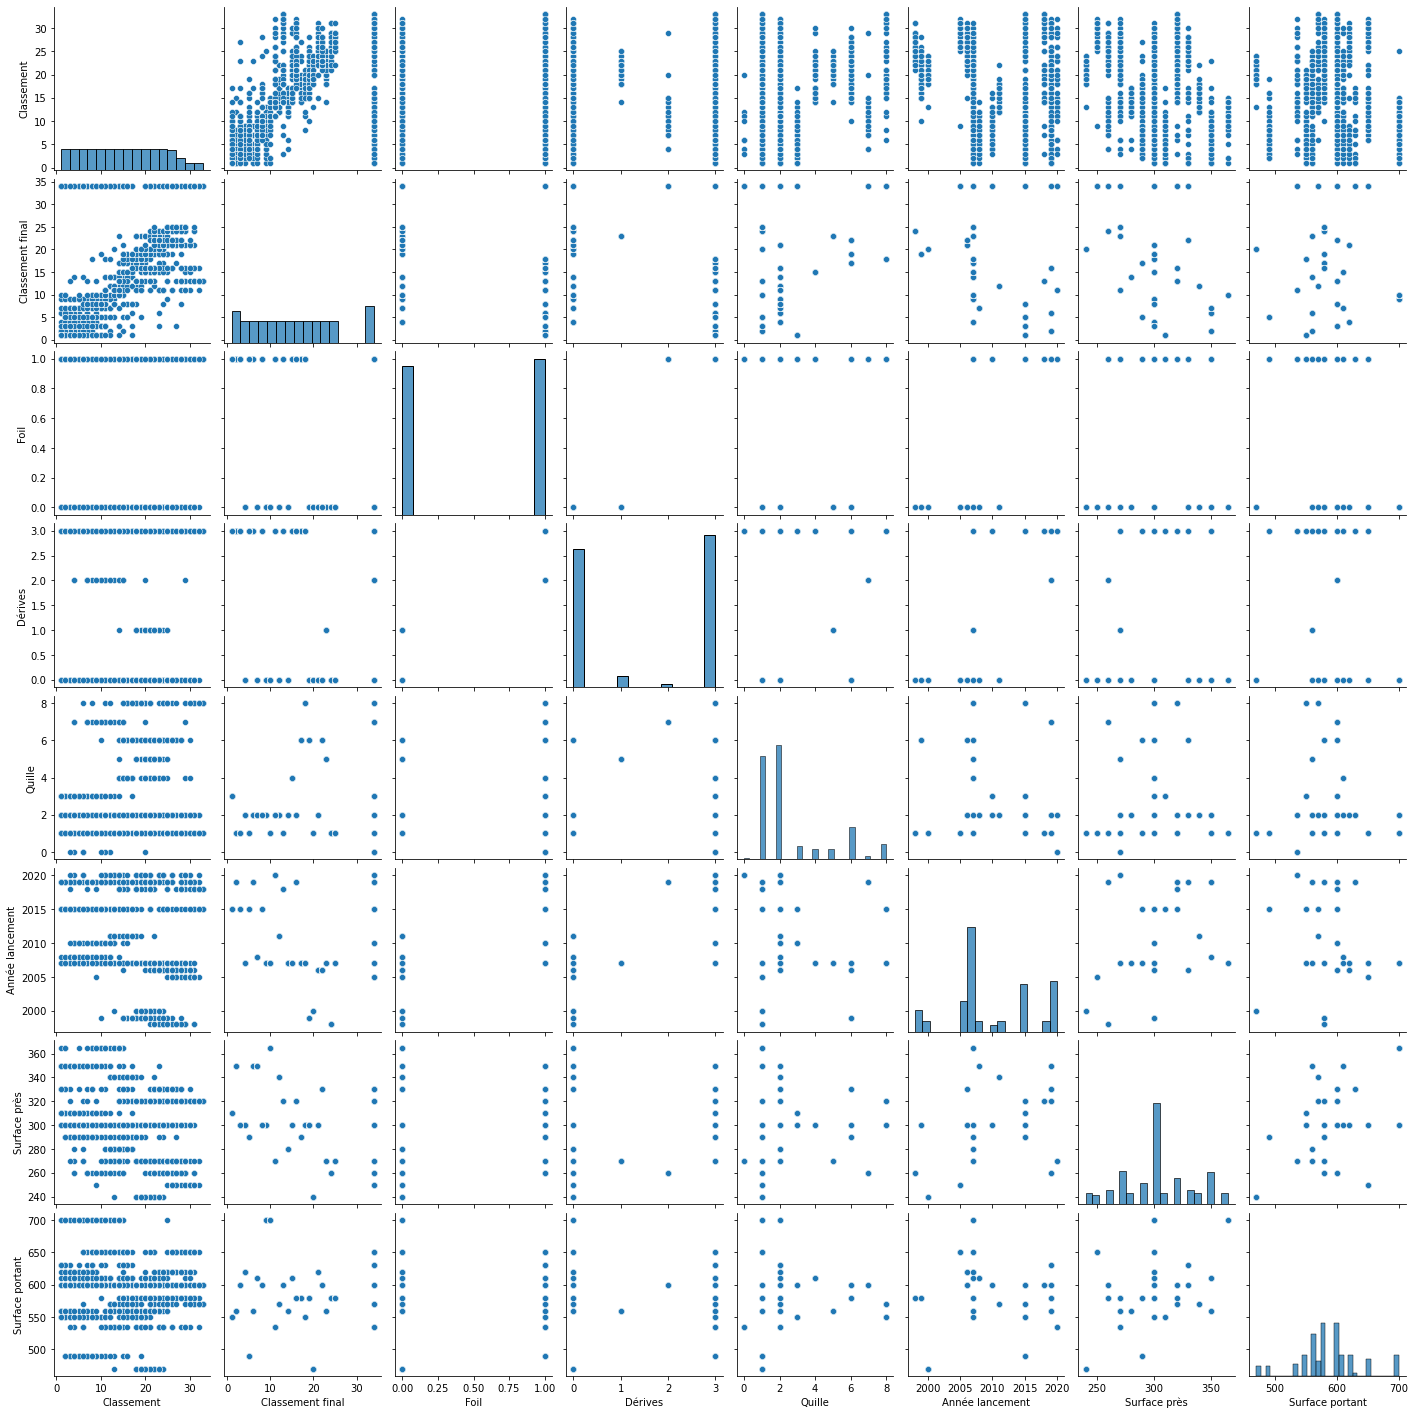

In [19]:
sns.pairplot(df4)
df4.columns

Index(['Classement', 'Classement final', 'Cap 24h', 'VMG 24h', 'Distance 24h',
       'Tirant', 'Longueur'],
      dtype='object')

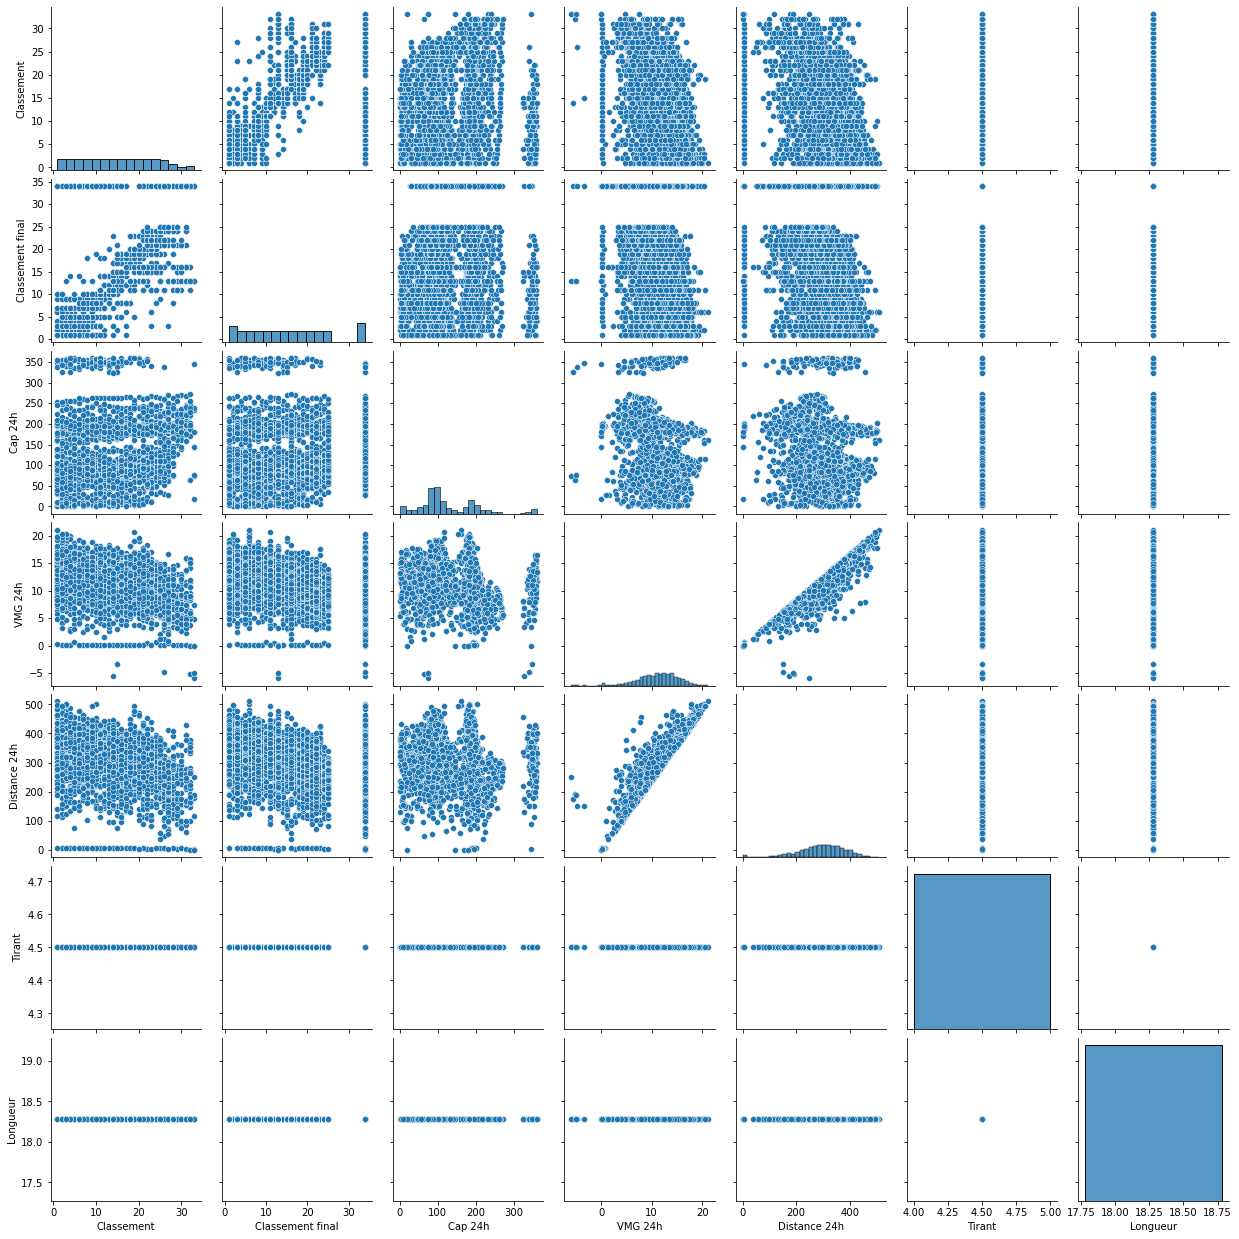

In [20]:
sns.pairplot(df1)
df1.columns

Index(['Classement', 'Classement final', 'DTF', 'DTL', 'Vitesse 24h',
       'Largeur'],
      dtype='object')

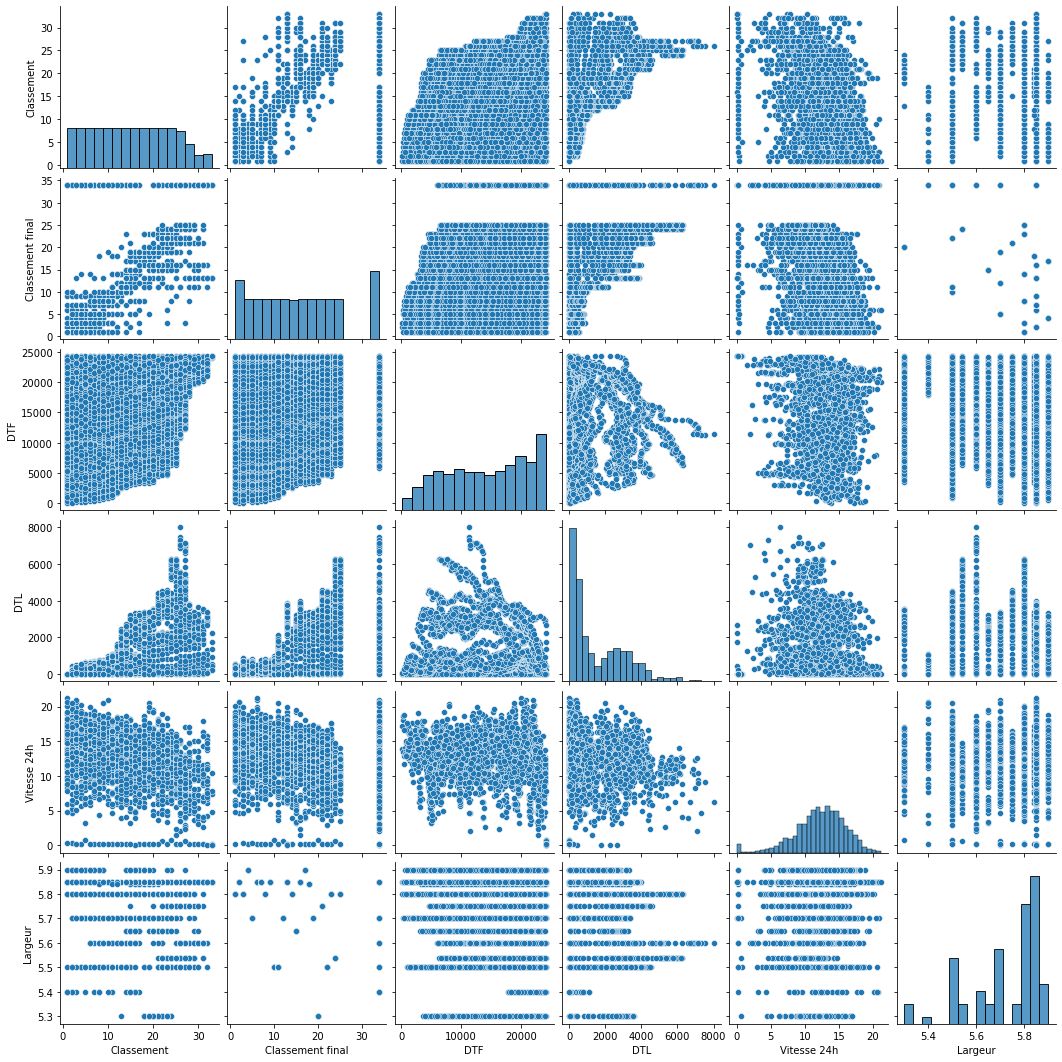

In [21]:
sns.pairplot(df2)
df2.columns

Index(['Classement', 'Classement final', 'Poids', 'Hauteur mât',
       'Surface près', 'Surface portant', 'Année lancement'],
      dtype='object')

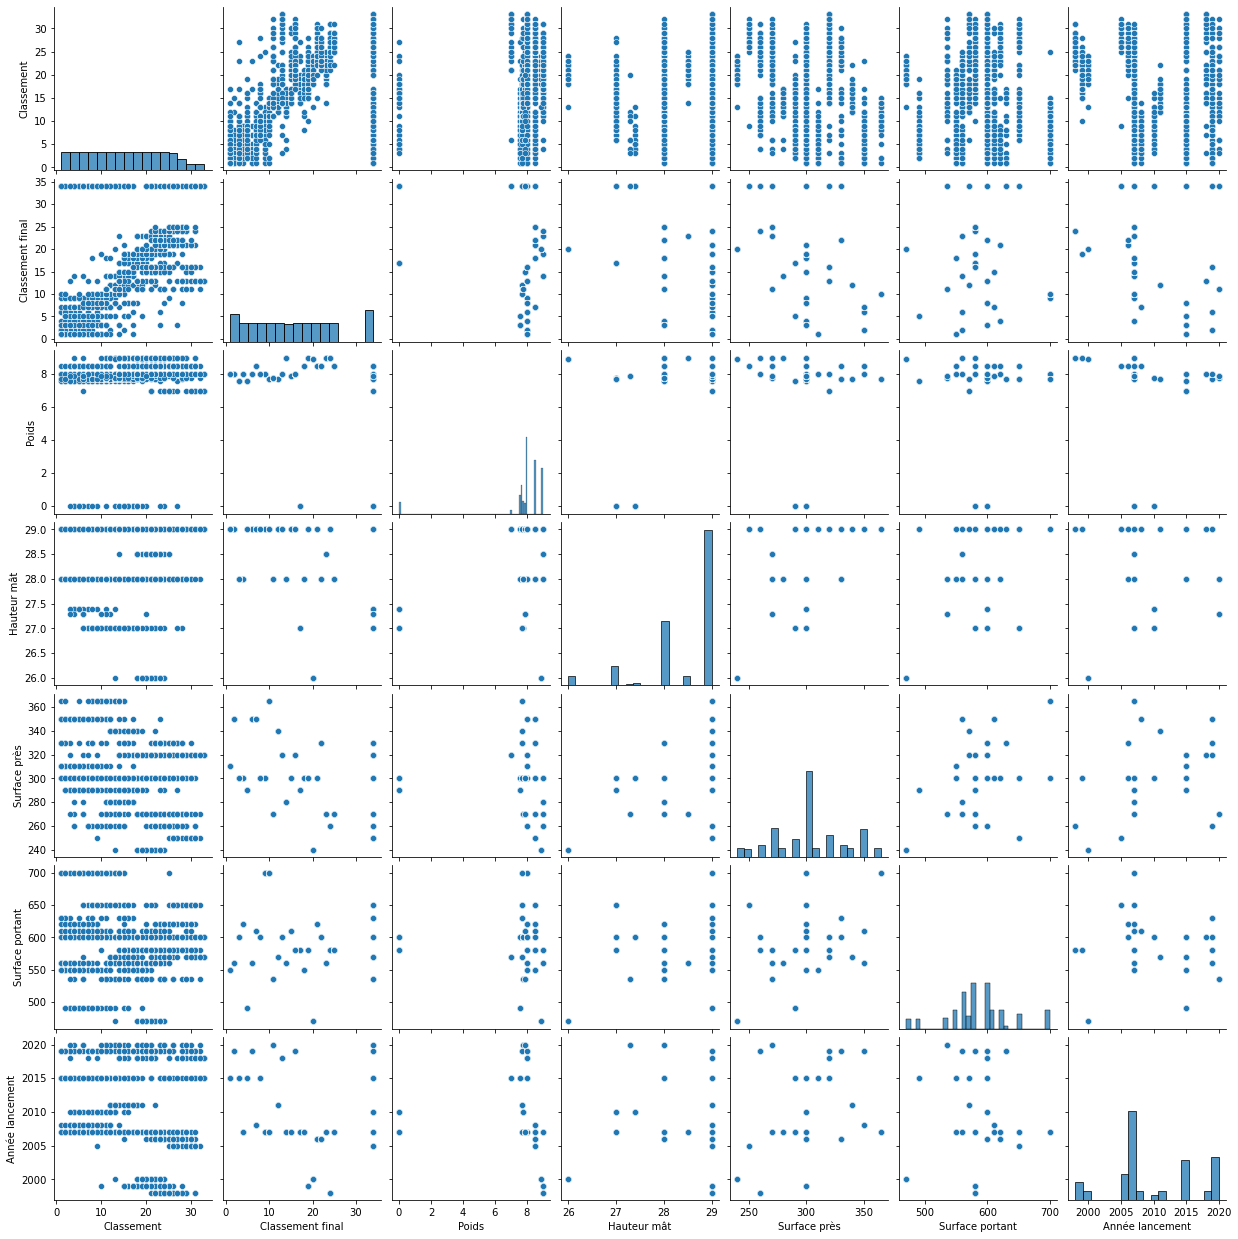

In [26]:
sns.pairplot(df3)
df3.columns

In [27]:
# pairplot sur 6 composantes sélectionnes aléatoirement
# Tracé du Scatterplot

# df_sample = num_df.sample(n=10,axis='columns')
# df_sample[nom_colonne_y] = Y
# df_sample.head()

# sns.pairplot(df_sample)


In [28]:
nom_colonne_y = "Classement final"

def show_graphs(num_df, nom_colonne_y):
    Y = num_df[nom_colonne_y]
    X_cols=[]
    X_cols = num_df.columns.to_list()
    # on enlève le nom de la colonne Y
    X_cols.remove(nom_colonne_y)

    X = num_df[X_cols]

    ncols=3
    nrows=int((len(num_df.columns)-1)/ncols)+ min(1, (len(num_df.columns)-1)%ncols)

    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(25 , 25))

    

    for i, ax ,col in zip(range(len(num_df.columns)-1), axes.flat, X_cols):
        ax.scatter(Y, X[col])
        ax.set_title(col + "/"+nom_colonne_y , fontsize = 16)
        ax.set_xlabel(nom_colonne_y, fontsize = 16)
        ax.set_ylabel(col, fontsize = 16)
    #     sns.distplot(data[i,0,0,0], hist=False, ax=ax)
    fig.tight_layout()
    plt.show()
    
    
def show_one_graph(num_df, nom_colonne_y, nom_colonne_x):
    Y = num_df[nom_colonne_y]
    X_cols=[nom_colonne_x]    
    X = num_df[X_cols]

    ax = plt.subplot(111)
    ax.scatter(Y, X)
    ax.set_title(nom_colonne_x + "/" + nom_colonne_y , fontsize = 16)
    ax.set_xlabel(nom_colonne_y, fontsize = 16)
    ax.set_ylabel(nom_colonne_x, fontsize = 16)
#     fig.tight_layout()
    plt.show()
    


In [36]:

def show_one_graph(df, nom_colonne_x, nom_colonne_y):
    Y = df[nom_colonne_y]
    X_cols=[nom_colonne_x]    
    X = df[X_cols]

    ax = plt.subplot(111)
    ax.scatter(Y, X)
    ax.set_title(nom_colonne_x + "/" + nom_colonne_y , fontsize = 16)
    ax.set_xlabel(nom_colonne_y, fontsize = 16)
    ax.set_ylabel(nom_colonne_x, fontsize = 16)
#     fig.tight_layout()
    plt.show()

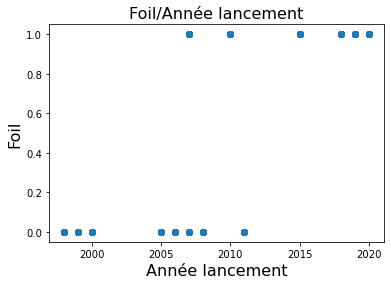

In [37]:
show_one_graph(num_df, "Foil", "Année lancement")

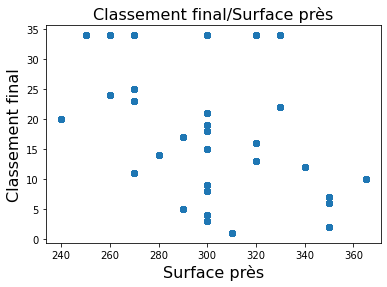

In [38]:
show_one_graph(num_df,  "Classement final", "Surface près")


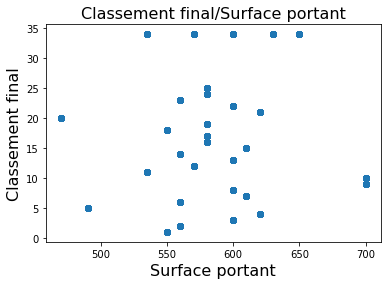

In [39]:
show_one_graph(num_df,  "Classement final", "Surface portant")


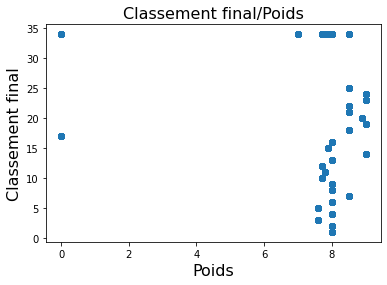

In [40]:
show_one_graph(num_df,  "Classement final", "Poids")


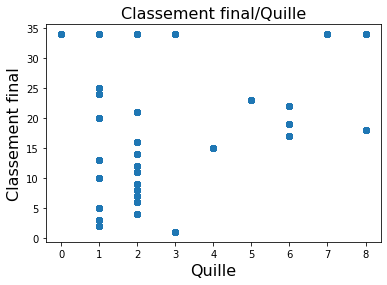

In [41]:
df['Année lancement']
show_one_graph(num_df,  "Classement final", "Quille")


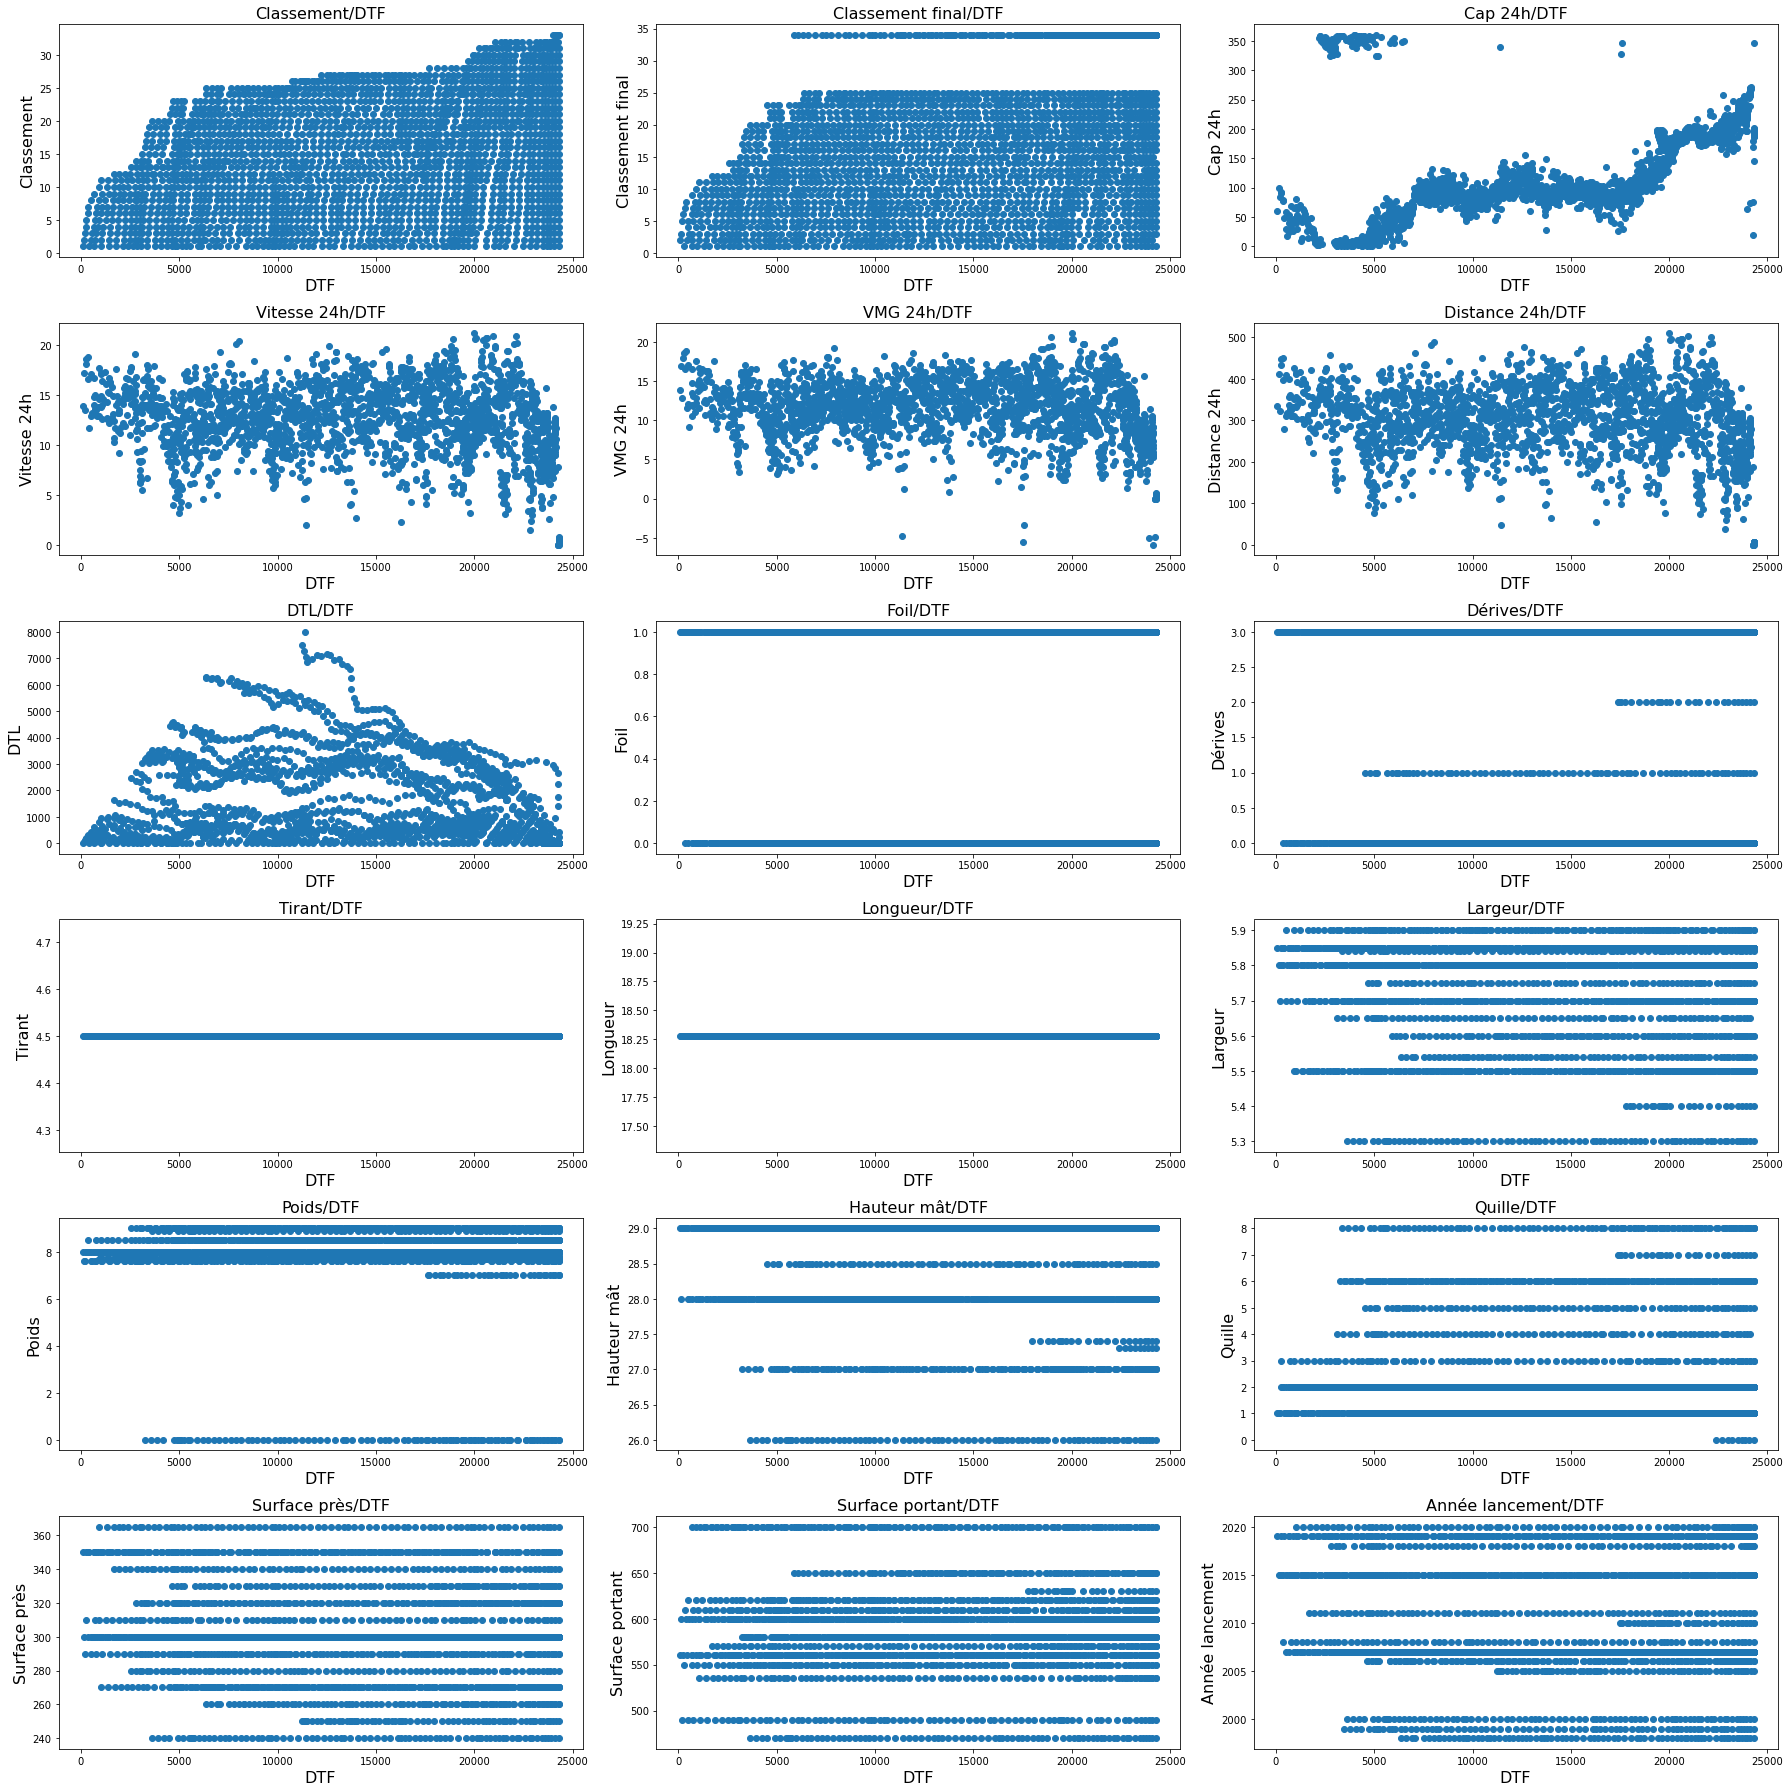

In [35]:
show_graphs(num_df, "DTF")

1 34
2302


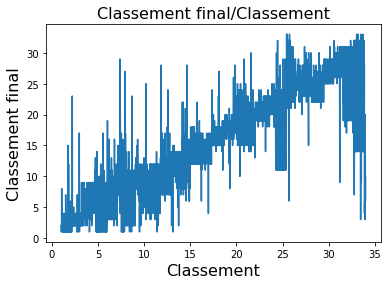

In [48]:
    
def show_plot_graph(num_df, nom_colonne_y, nom_colonne_x):
    Y = num_df[nom_colonne_y]
    X_cols=[nom_colonne_x]    
    X = num_df[X_cols]
    xmin = X.min()[0]
    xmax = X.max()[0]
    print(xmin, xmax)
    print(len(Y))
    xabs = np.linspace(xmin, xmax, len(Y))
    ax = plt.subplot(111)
    ax.plot(xabs, Y)
    ax.set_title(nom_colonne_x + "/" + nom_colonne_y , fontsize = 16)
    ax.set_xlabel(nom_colonne_y, fontsize = 16)
    ax.set_ylabel(nom_colonne_x, fontsize = 16)
#     fig.tight_layout()
    plt.show()
    
show_plot_graph(num_df,  "Classement", "Classement final")

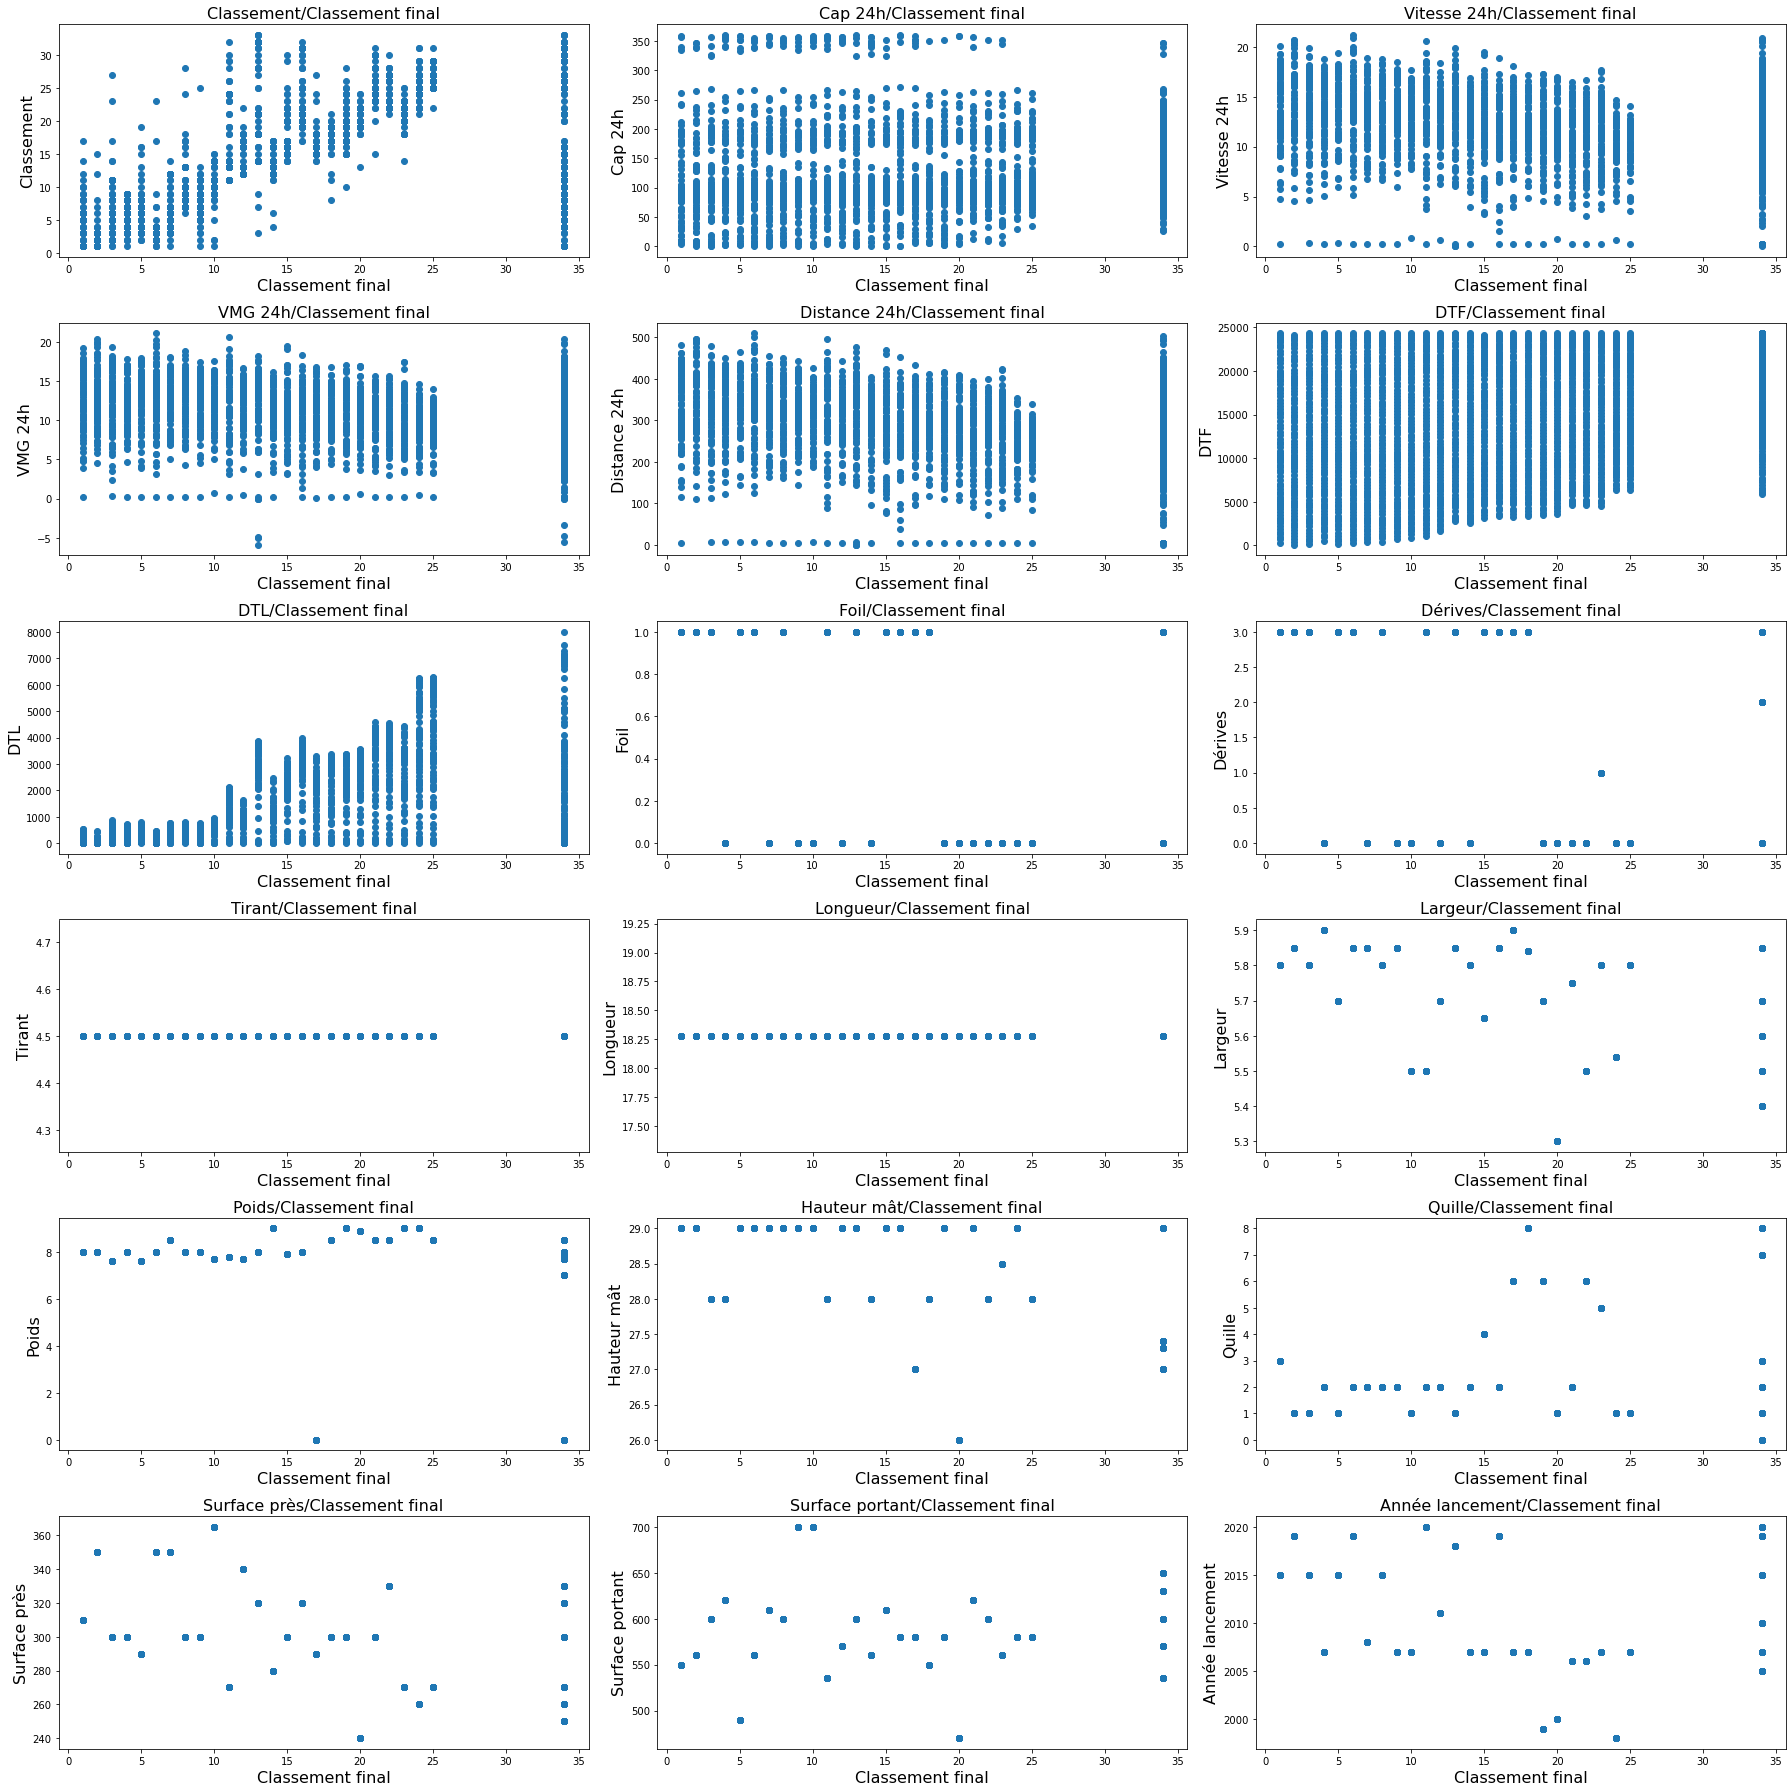

In [49]:
show_graphs(num_df, nom_colonne_y)

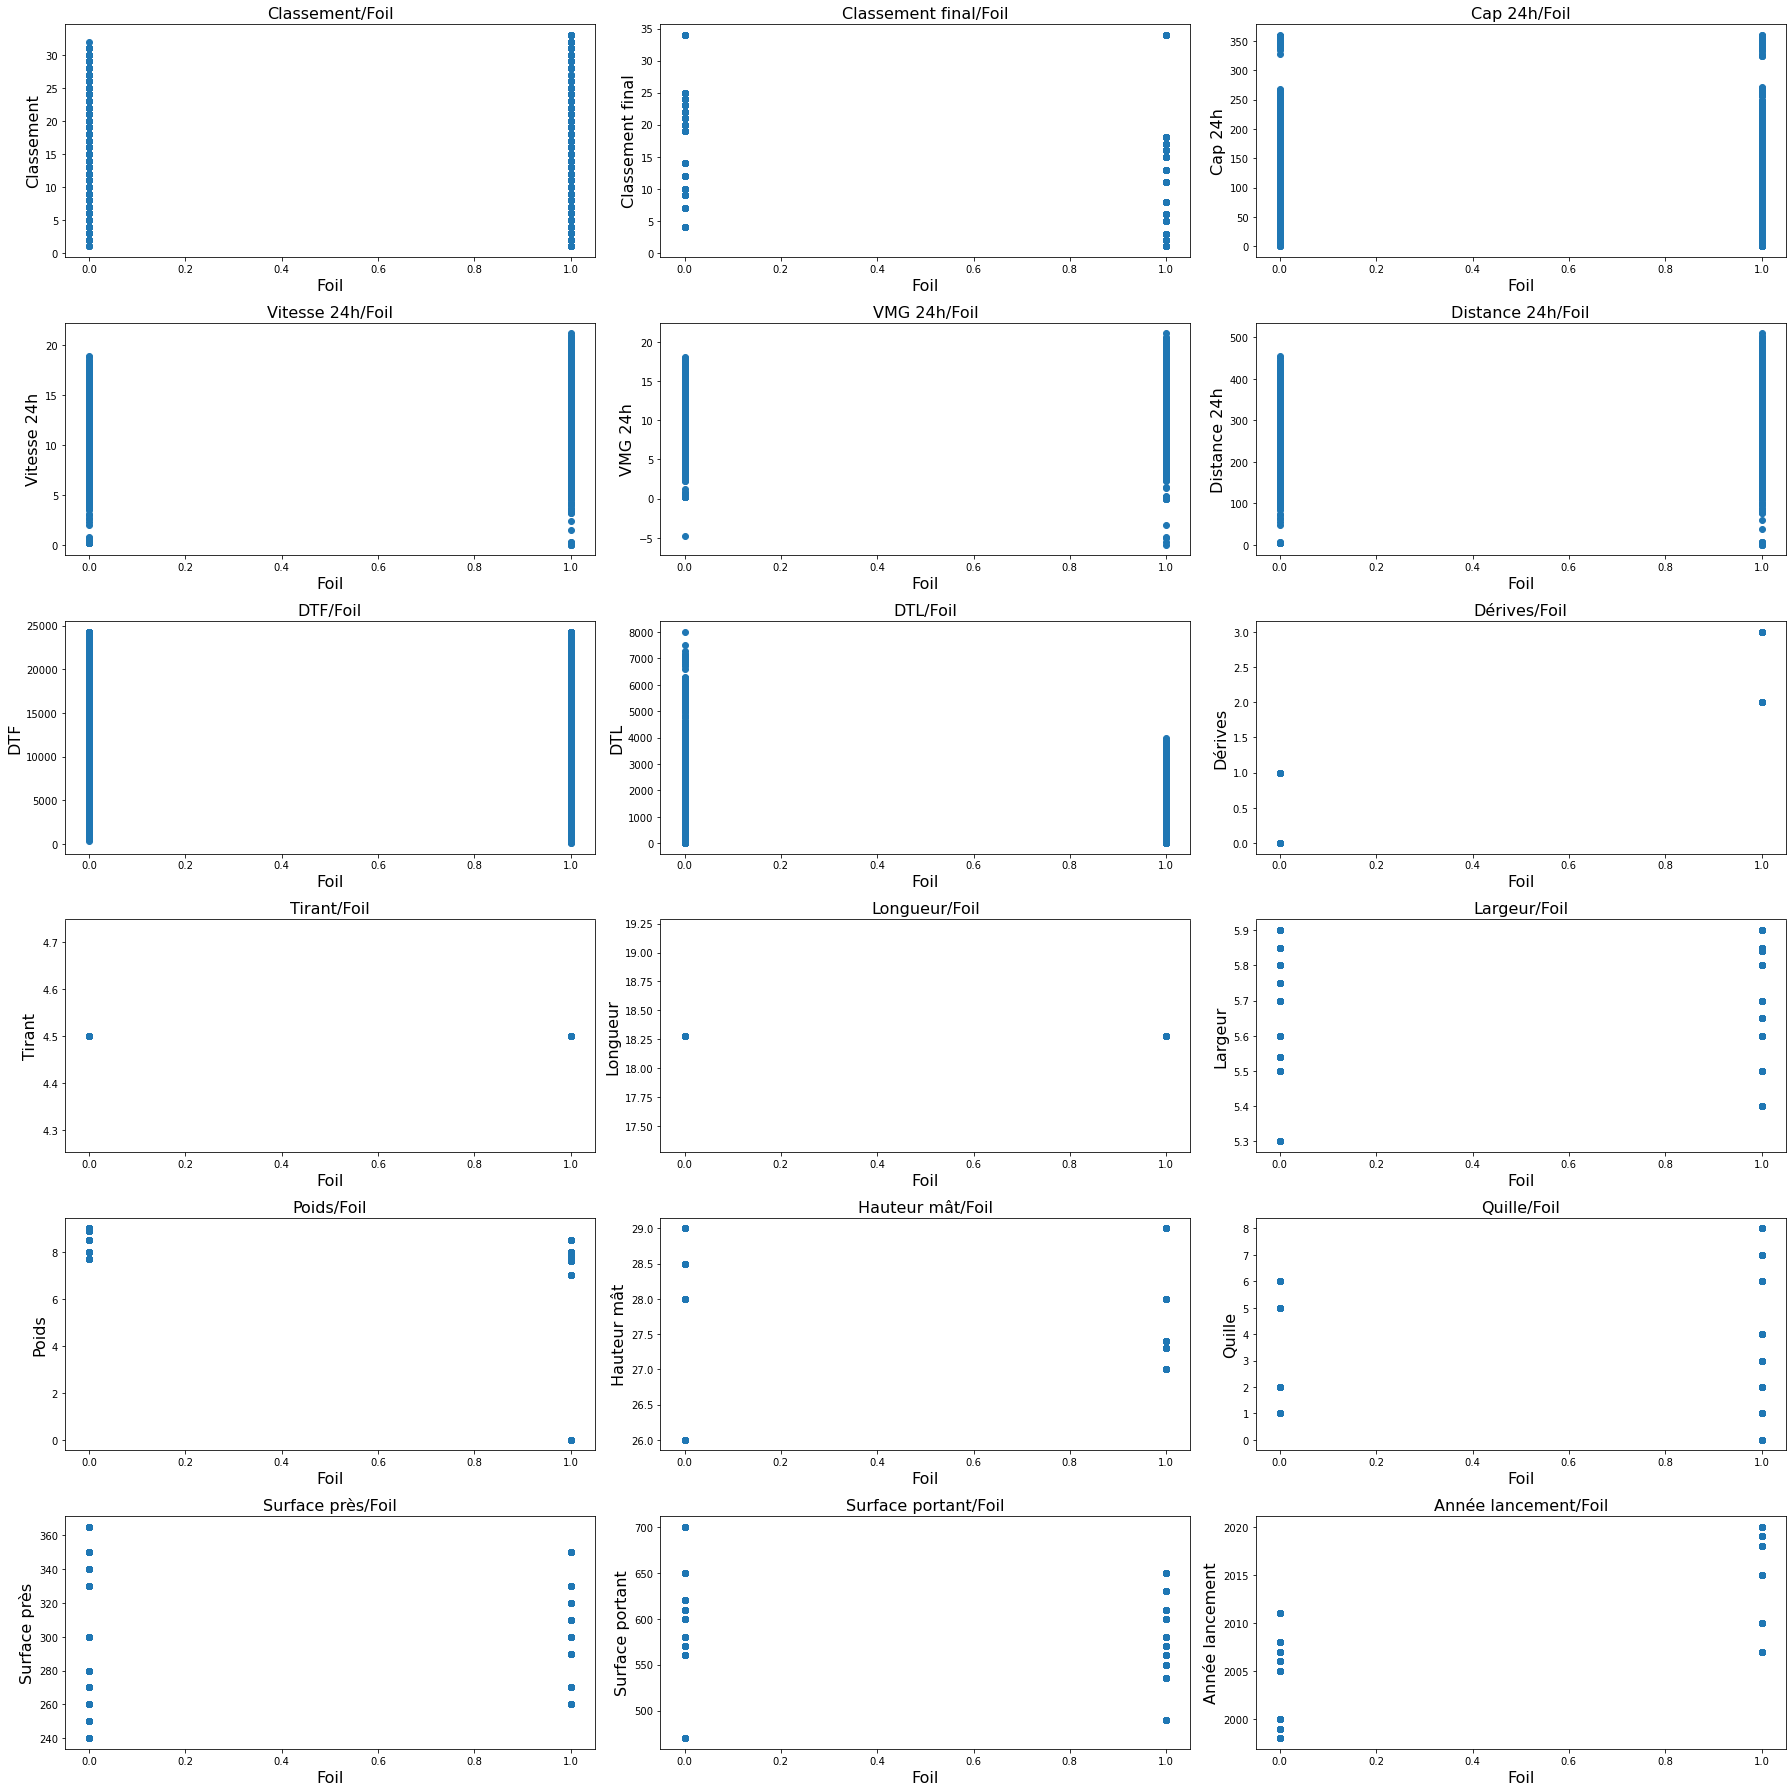

In [50]:
show_graphs(num_df, "Foil")

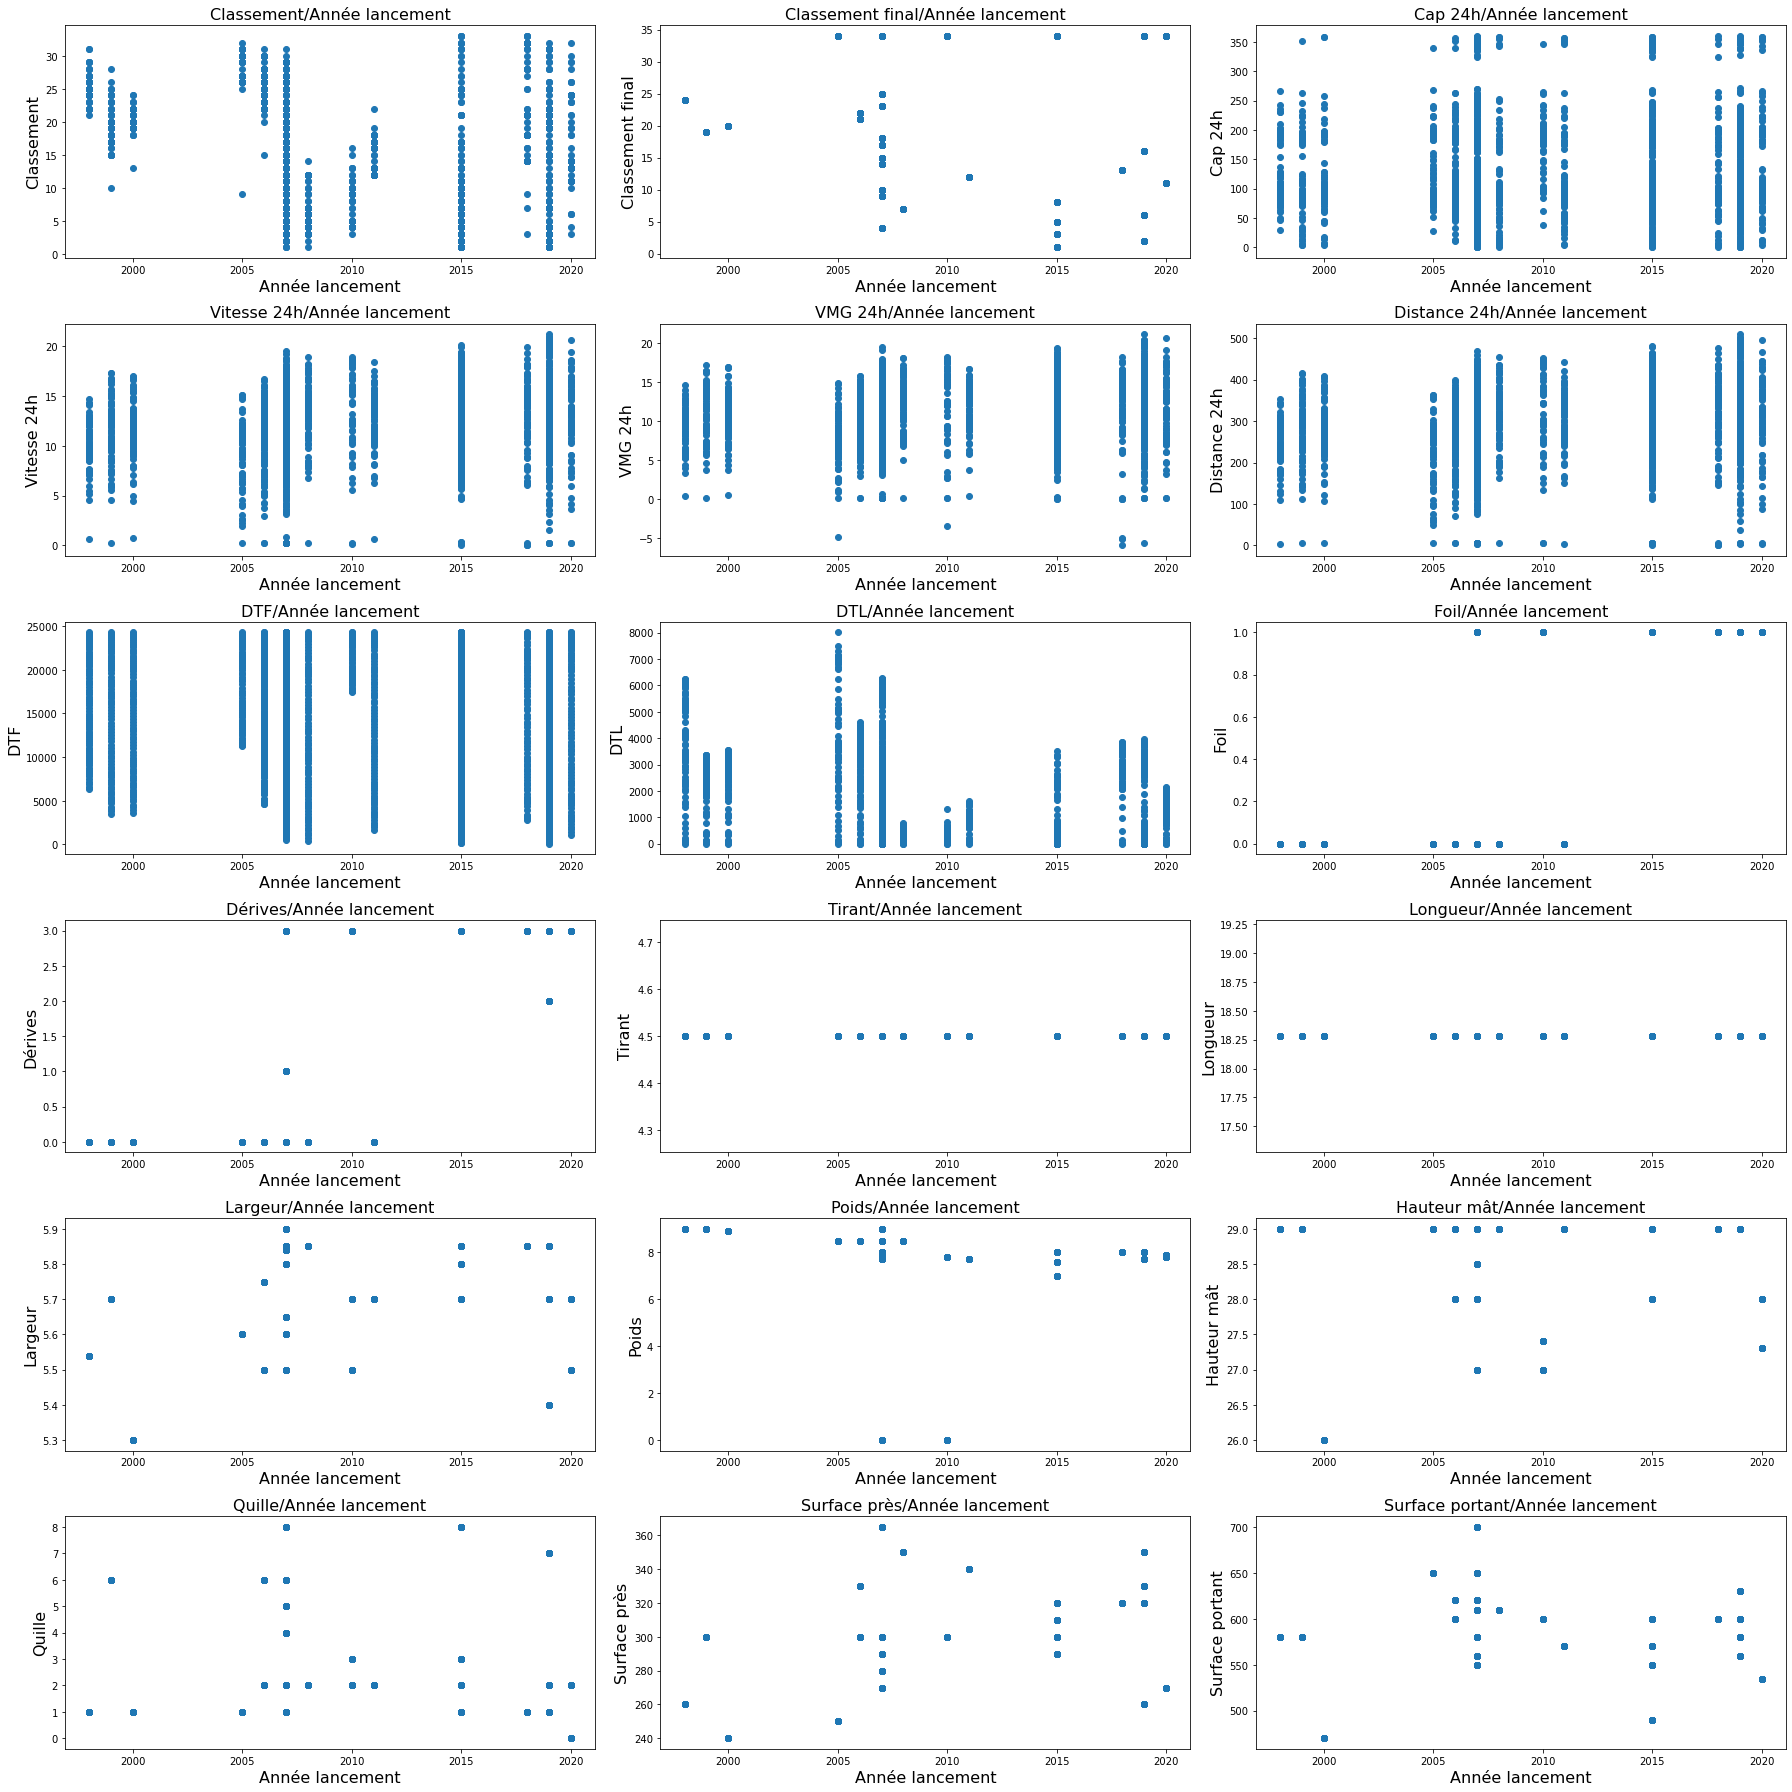

In [51]:
show_graphs(num_df, "Année lancement")

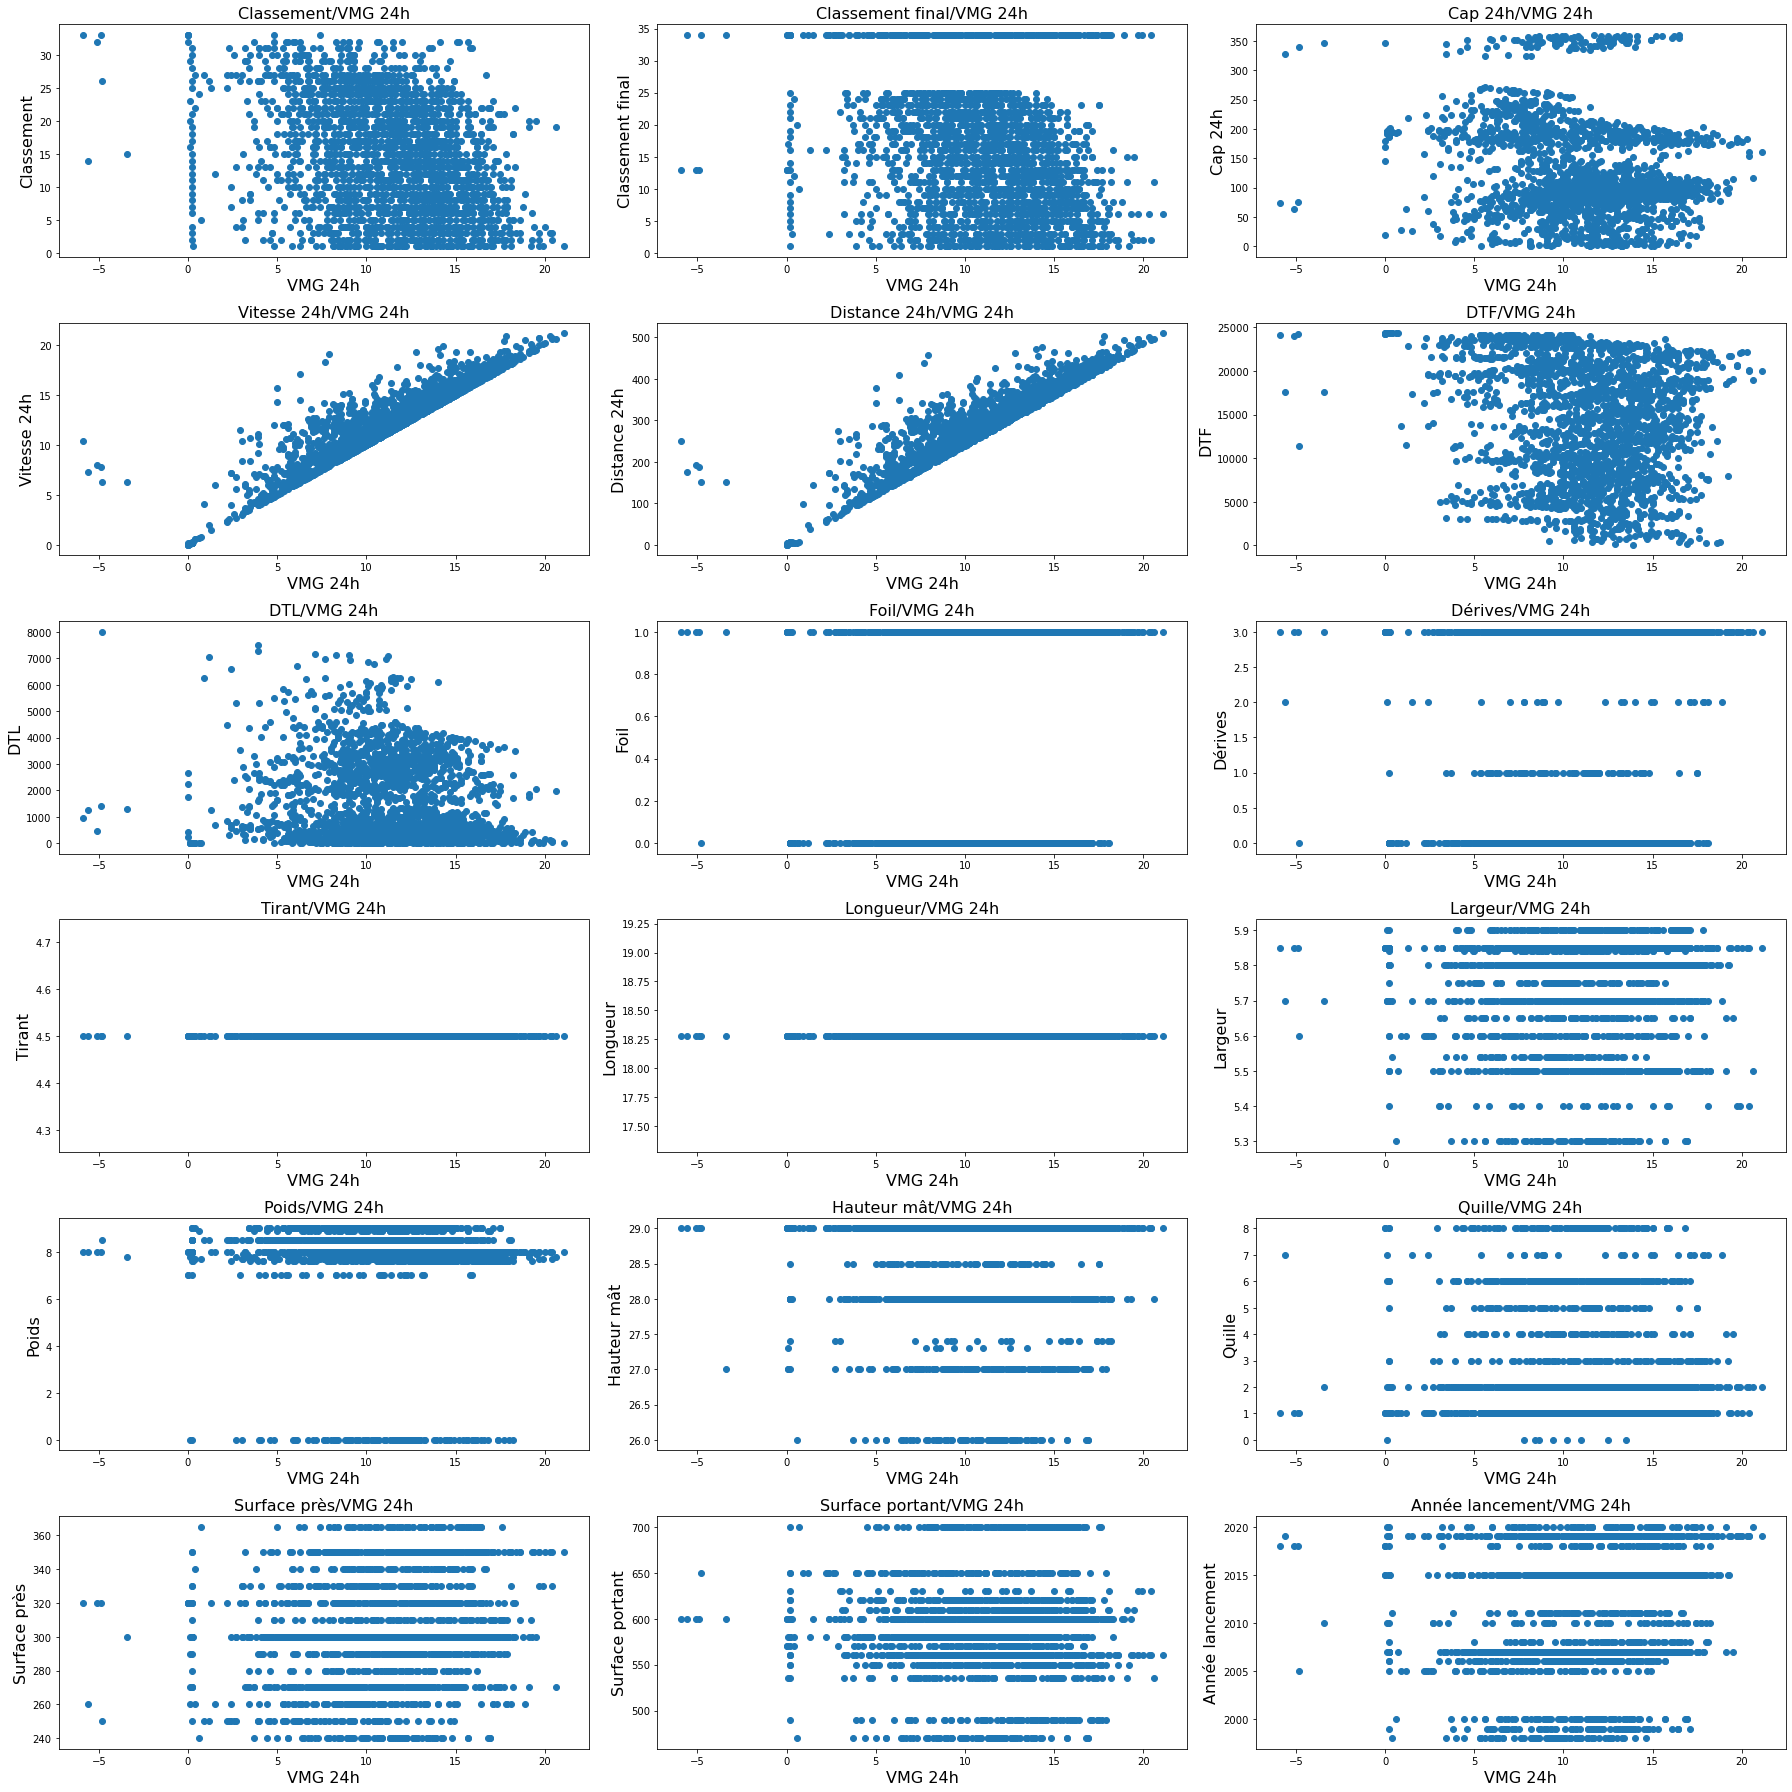

In [52]:
show_graphs(num_df, "VMG 24h")

In [ ]:
# for col in num_df.columns:
#     if col != 'Classement final':
#         plt.figure(figsize=(5, 4), dpi=80)

#         # On trace
#         plt.scatter(Y, X[col])
#         # On légende
#         plt.title(col + "/Classement final" , fontsize = 14)
#         plt.xlabel("Classement final", fontsize=12)
#         plt.ylabel(col, fontsize=12)


In [ ]:
##############################################################
## Fonction qui convertit les coordonnées en format décimal ##
##############################################################

def dms2dec(deg, mn, sec):
    return deg + mn / 60 + sec / 3600

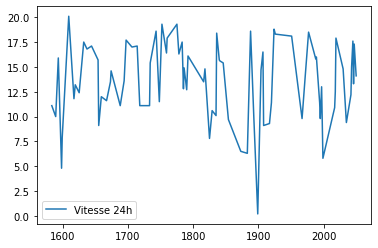

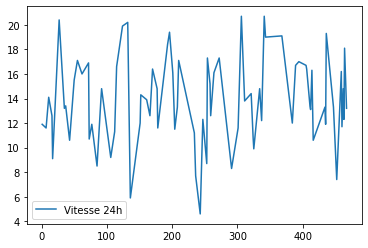

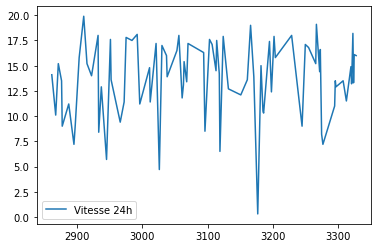

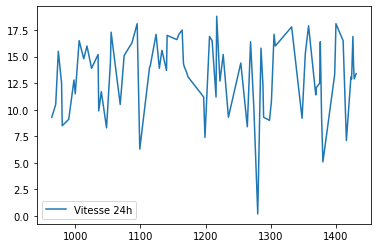

In [67]:
# remove nan lines
# extract pour chaque bateau la vitesse / 24 en histogramme
# correlation vitesse distance
# 
dfz= df_classements_14h.copy()
dfz.set_index('Timestamp')
dfz
for i  in [1, 2, 3 ,4 ]:
    dfz.loc[dfz['Classement final']==i, ['Vitesse 24h']].plot()


1582    Yannick Bestaven
1583    Yannick Bestaven
1584    Yannick Bestaven
1585    Yannick Bestaven
1586    Yannick Bestaven
              ...       
2059    Yannick Bestaven
2060    Yannick Bestaven
2061    Yannick Bestaven
2062    Yannick Bestaven
2063    Yannick Bestaven
Name: Skipper, Length: 482, dtype: object

In [90]:

df = df.reset_index()
df = df.set_index('Timestamp').sort_index()
df

,level_0,index,Classement,Classement final,Skipper,Bateau,Voile,Pays,Heure FR,Latitude,...,Tirant,Longueur,Largeur,Poids,Hauteur mât,Quille,Surface près,Surface portant,Année lancement,Ancien nom
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-11-08 14:00:00,9015,9015,24,20,Didac Costa,One Planet One Ocean,ESP 33,,15:30 FR,46°25.59'N,...,4.5,18.28,5.30,8.9,26.0,1,240.0,470.0,2000,Kingfisher
2020-11-08 14:00:00,2654,2654,29,34,Sébastien Simon,ARKEA PAPREC,FRA 4,,15:29 FR,46°25.75'N,...,4.5,18.28,5.70,8.0,29.0,7,260.0,600.0,2019,ARKEA PAPREC
2020-11-08 14:00:00,3454,3454,16,34,Samantha Davies,Initiatives - Coeur,FRA 109,,15:30 FR,46°25.62'N,...,4.5,18.28,5.70,7.8,27.0,2,300.0,600.0,2010,Maître CoQ
2020-11-08 14:00:00,13006,13006,19,16,Kojiro Shiraishi,DMG MORI Global One,JPN 11,,15:31 FR,46°25.42'N,...,4.5,18.28,5.85,8.0,29.0,2,320.0,580.0,2019,DMG MORI Global One
2020-11-08 14:00:00,1280,1280,7,4,Jean Le Cam,Yes we Cam !,FRA 01,,15:30 FR,46°24.90'N,...,4.5,18.28,5.90,8.0,28.0,2,300.0,620.0,2007,"Cheminées Poujoulat, Mare, Maître CoQ, Mapfre,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-27 14:00:00,6934,6934,16,17,Alan Roura,La Fabrique,SUI 7,,14:30 FR,00°20.92'S,...,4.5,18.28,5.90,0.0,27.0,6,290.0,580.0,2007,"Brit Air, Votre Nom autour du Monde, MACSF"
2021-01-27 14:00:00,161,161,1,2,Charlie Dalin,APIVIA,FRA 79,,14:30 FR,46°14.07'N,...,4.5,18.28,5.85,8.0,29.0,1,350.0,560.0,2019,APIVIA
2021-01-27 14:00:00,6452,6452,13,14,Romain Attanasio,Pure - Best Western Hotels and Resorts,FRA 49,,14:30 FR,14°12.07'N,...,4.5,18.28,5.80,9.0,28.0,2,280.0,560.0,2007,"Gitana Eighty, Synerciel, Newrest"


PLOT PAR SKIPPERS

['Jean Le Cam' 'Louis Burton' 'Yannick Bestaven' 'Charlie Dalin']


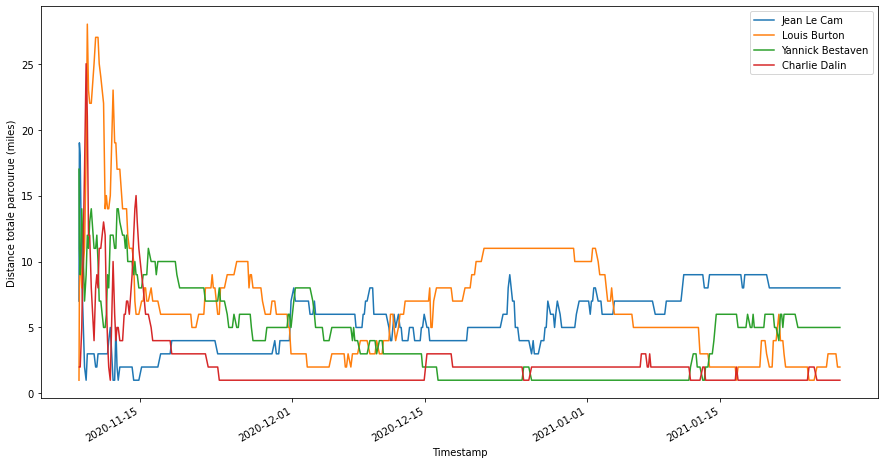

In [100]:
fig = plt.subplots(1, figsize=(15,8))

skips = df.loc[df['Classement final'].isin(range(1,5)), "Skipper"].unique()

print(skips)
for skipper in skips:
    skip = df.loc[(df['Skipper'] == skipper),"Classement"]
    skip.plot(label = skipper)

plt.ylabel('Distance totale parcourue (miles)')
plt.legend();

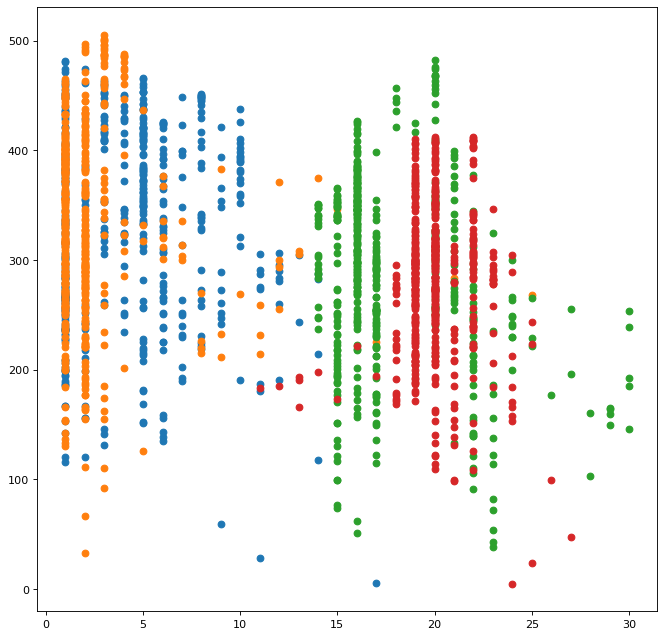

In [68]:
# 
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=80)

for i in [1, 2, 15, 20]:
    s = df.loc[df['Classement final']==i]
    X = s['Classement']
    Y = s['Distance 24h']
    x = np.linspace(0, len(s)/4, len(s))
    ax.scatter(X, Y)

Yannick Bestaven et Charlie Dalin, tous deux en tête du classement, ont des performances semblables en terme de vitesse utile tout au long de la série temporelle.
Aliexia Barrier, en fin de classement, a été presque constamment en dessous de leurs vitesses utile ce qui a très certainement joué un impact dans son rang. 


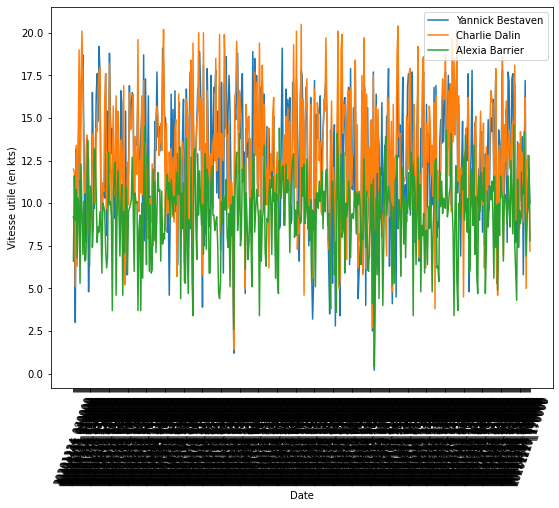

In [72]:
skippers = ['Yannick Bestaven', 'Charlie Dalin', 'Alexia Barrier']

def time_series(df, skippers):
    
    df_run = df.loc[(df['Classement final'] != 34), ['Skipper', 'VMG 24h', 'Fichier de resultats']]  
    
    plt.figure(2, figsize=(9, 7))
    
    for skipper in skippers:
        df_skipper = df_run.loc[df_run['Skipper'] == skipper, ['VMG 24h', 'Fichier de resultats']]
        plt.plot(df_skipper['Fichier de resultats'], df_skipper['VMG 24h'], label=skipper) 
    
    plt.xticks(rotation=70)
    plt.xlabel('Date')
    plt.ylabel('Vitesse utile (en kts)')
    plt.legend(loc='upper right')
    plt.plot()
    
    print('Yannick Bestaven et Charlie Dalin, tous deux en tête du classement, ont des performances semblables en terme de vitesse utile tout au long de la série temporelle.')
    print('Aliexia Barrier, en fin de classement, a été presque constamment en dessous de leurs vitesses utile ce qui a très certainement joué un impact dans son rang. ')

time_series(df, skippers)    
    

In [ ]:
# MATPLOTLIB
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=80)
 
skippers_list=df_classements_14h.Skipper.unique().tolist()
for k in skippers_list[10:13]:
    tmp = df_classements_14h[df_classements_14h.Skipper == k]
    ax.plot(tmp['Fichier de resultats'], tmp['Classement'], label=k)
 
    ax.set(xlabel='Date', ylabel='Classement', title='Resultat Timeseries')
 
    ax.legend(loc=2)
    
    fig.autofmt_xdate()

In [ ]:
df['Fichier de resultats'].apply(lambda x: x.split('_')[1])=="080000"

# 
fig, ax = plt.subplots(1,1)
for i in [1, 20]:
    s = df.loc[df['Classement final']==i & 
    df['Fichier de resultats'].apply(lambda x: x.split('_')[1])=="080000"]
    pass
#     print(s2)
#     X = s2['Classement']
#     Y = s2['Distance 24h']
    
#     x = np.linspace(0, len(s)/4, len(s))
#     ax.plot(x, Y)

    

In [ ]:
# 
fig, ax = plt.subplots(1,1)

for i in range(0, 2):
    s = num_df.loc[num_df['Classement']==i]
    X = s['Foil']
    Y = s['VMG 24h']
    
    xxbar = (X - X.mean())
    covX = xxbar@xxbar.T
    print(covX)
    covXY = xxbar@(Y - Y.mean())
    print(covXY)
    x = np.linspace(0, len(s), len(s))
    ax.plot(Y, x)
    
num_df["VMG 24h"].min()

In [ ]:
# ### https://cedric.cnam.fr/vertigo/Cours/ml/tpAcp.html ### #

import numpy as np
# Génération de données selon une loi normale tridimensionnelle
rndn3d = np.random.randn(500,3)
#rndn3d = np.array([ num_df["Foil"].to_list(), num_df["VMG 24h"].to_list(), num_df["Classement final"].to_list() ])

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Affichage du nuage de points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rndn3d[:,0], rndn3d[:,1], rndn3d[:,2])
plt.title("Données initiales")
plt.show()

# 
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(rndn3d)

print("Pourcentage de variance expliquée : ")
print(pca.explained_variance_ratio_)
print("Composantes principales : ")
print(pca.components_)

#
s1 = np.array([[3,0,0],[0,1,0],[0,0,0.2]])  # matrice de déformation
r1 = np.array([[0.36,0.48,-0.8],[-0.8,0.6,0],[0.48,0.64,0.6]])  # matrice de rotation
rndef = rndn3d.dot(s1).dot(r1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rndef[:,0], rndef[:,1], rndef[:,2])
plt.title("Données déformées")
plt.show()


# 
pca = PCA(n_components=3)
pca.fit(rndef)

print("Pourcentage de variance expliquée : ")
print(pca.explained_variance_ratio_)
print("Composantes principales : ")
print(pca.components_)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

for i in [1, 2, 15, 20]:
    fig = plt.figure(figsize=(20, 20), dpi=80)
    ax = fig.add_subplot(111, projection='3d')

    x2 = df.loc[df['Classement final']==i]
    x3 = df['Distance 24h'] 
    x1 = df['Classement']
    
    x = np.linspace(0, len(s)/4, len(s))
    ax.scatter(X, Y)

In [ ]:
# Génération de données selon une loi normale tridimensionnelle
x3 = df['Distance 24h'] 
x2 = df['Classement final'] 
x1 = df['Classement']

# Affichage du nuage de points
fig = plt.figure(figsize=(20, 20), dpi=80)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, x3)

ax.set_zlabel('Distance 24h')
ax.set_ylabel('Classement final')
ax.set_xlabel('Classement')
plt.title("Données initiales")
plt.show()

In [ ]:
# séries temporelles
# évolution de la position du bateau dans le classement par rapport à l'ordre d'arrivée



In [ ]:
# évolution de la vitesse par tranche de latitude
# distance / vitesse pour vérifier corrélation
# vitesse / présence foil
# classement / présence foil
# cl et vit / foil
# 

In [ ]:

# Fixing random state for reproducibility
np.random.seed(19680801)

# some random data
x = np.random.randn(500)
y = np.random.randn(500)


def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')
    
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(x, y, ax, ax_histx, ax_histy)

plt.show()

* Rapprochement des données des voiliers avec celle des classements.
* Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.
* Impact de la présence d'un foil sur le classement et la vitesse des voiliers.
* Visualisation de la distance parcourue par voilier.
* Cartes avec les routes d'un ou plusieurs voiliers.
* Analyses de séries temporelles.
* Application d'algorithmes statistiques ou de machine learning.
* etc.